<div class = "alert alert-block alert-info">
    
# Introduction

## Prediction of chronic kidney disease based on measurements in blood and urine tests

Chronic kidney disease can be debilitating to those who have it and it is also very expensive for treatment, requiring dialysis machines to filter the blood due to weakened kidneys or surgery for transplant. In this data analysis project, measurements in blood and urine tests will be used to try and predict the presence of chronic kidney disease. Accurate prediction of whether or not a patient has chronic kidney disease can be greatly beneficial for the medical system in terms of cost and time savings. In the models being created to predict chronic kidney disease below, the focus will be on the results in blood test of patients. Information from urine tests will not be used.
</div>

In [1]:
install.packages("e1071")
install.packages("GGally")
install.packages("corrplot")
library(tidyverse)
library(caret)
library(repr)
library(GGally)
library(corrplot)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

corrplot 0.84 loaded


## Table separating Quantitative and Qualitative data ##
| Numerical/quantitative data | Nominal/Qualitative data|
------------------------------|-----------------|
|age **(age)**                     |specific gravity **(sg)**|
|blood pressure **(bp)**           |albumin **(al)**|
|blood glucose random **(bgr)**    |sugar **(su)**|
|blood urea **(bu)**               |red blood cells **(rbc)**|
|serum creatinine **(sc)**         |pus cell **(pc)**|
|sodium **(sd)**                   |pus cell clumps **(pcc)**|
|potassium **(pot)**               |bacteria **(ba)**|
|hemoglobin **(hemo)**             |hypertension **(htn)**|
|packed cell volume **(pcv)**      |diabetes mellitus **(dm)**|
|white blood cell count **(wbcc)** |coronary artery disease **(cad)**|
|red blood cell count **(rbcc)**   |appetite **(appet)**|
|NA                           |pedal edema **(pe)**|
|NA                           |anemia **(ane)**|
|NA                           |**class**|

## Units of the numerical/quantitative data ##
| Numerical/quantitative data | 
------------------------------|
|age **(years)**                     |
|blood pressure **(mm/Hg)**           |
|blood glucose random **(mg/dl)**    |
|blood urea **(mg/dl)**               |
|serum creatinine **(mg/dl)**         |
|sodium **(mEq/L)**                   |
|potassium **(mEq/L)**               |
|hemoglobin **(g/dl)**             |
|packed cell volume **(no unit given)**|
|white blood cell count **(cells/mm^3)**|
|red blood cell count **(millions of cells/mm^3)**|
|NA                           |
|NA                           |
|NA                           |

<div class="alert alert-block alert-info">
In our case, we are only concerned about the quantitative/numerical data in the data set as we do not yet know how to use qualitative data for knn-classification
</div> 


In [2]:
kidney <- read_csv("https://raw.githubusercontent.com/UBC-DSCI/datasets/master/chronic_kidney_disease/chronic_kidney_disease_full.csv") %>%
    mutate(class = as.factor(class))                   # required to be able to use confusionMatrix for comparing prediction
                                                       # on the testing set to the actual testing set data.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


# <font color='blue'>Exploratory data analysis</font>

<div class = "alert alert-block alert-warning">
For the purpose of exploratory data analysis, we fill all the NA values in the data set with the mean in each column.
</div>

In [ ]:
class <- kidney %>%                                 # classes for each entry(ckd/notckd)
    select(class)

kidney_scaled <- kidney %>%                         # scaled values for data with class and NA values *NOT* replaced
    select(age, bp, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc) %>%
    scale(center = FALSE) %>%
    data.frame() %>%
    bind_cols(class)
head(kidney_scaled)

kidney_quantitative_scaled <- kidney %>%            # only scaled QUANTITATIVE values selected for this table
    select(age, bp, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc) %>%
    scale(center = FALSE) %>%
    data.frame()
head(kidney_quantitative_scaled)


In [ ]:
colMeans(kidney_quantitative_scaled, na.rm = TRUE)                # mean values of each column not including NA values.

for(i in 1:ncol(kidney_quantitative_scaled)){                     # kidney_quantitative_scaled
                                                                  # table NA values REPLACED with MEAN values in each column.
    kidney_quantitative_scaled[is.na(kidney_quantitative_scaled[,i]), i] <- 
    mean(kidney_quantitative_scaled[,i], na.rm = TRUE)
}

kidney_quantitative_scaled_w_class <- kidney_quantitative_scaled %>%
    bind_cols(class)                                               # scaled and NA replaced quantitative table bound to
                                                                   # class table.
head(kidney_quantitative_scaled_w_class)

In [ ]:
which(is.na(kidney_quantitative_scaled))                            # checking if any NA values still in the table
which(rowSums(is.na(kidney_quantitative_scaled)) != 0)
sum(is.na(kidney_quantitative_scaled))
colSums(is.na(kidney_quantitative_scaled))

kidney_quantitative_scaled_w_class <- na.omit(kidney_quantitative_scaled_w_class)     # used to omit rows in CLASS column
head(kidney_quantitative_scaled_w_class)                                              # with NA values (there were 3 rows).


summary(kidney_quantitative_scaled_w_class)            # gives us extra statistical information about each variable

In [ ]:
cor_matrix_kidney <- cor(kidney_quantitative_scaled)      # correlation matrix of variables
cor_matrix_kidney

# bu vs hemo, bu vs pcv, bu vs sc, hemo vs pcv, hemo vs rbcc, pcv vs rbcc are graphs we can start with.
# We chose these combinations based on their high correlation value between two variables.

In [ ]:
corrplot(cor_matrix_kidney)        # a visualization of the correlation matrix above

In [ ]:
ggpairs(kidney_quantitative_scaled_w_class, columns = c(4, 5, 6, 8, 9, 11, 12), mapping = ggplot2::aes(colour = class))

<div class = "alert alert-block alert-warning">
        Above is a plot matrix for exploratory data analysis. These variables are chosen based on making gppairs plot matrix of all the variables. We see that these variables are potential variables that can help us well predict the presence of chronic kidney disease. This is a smaller ggpairs plot matrix made for better visibility compared to the one where all variables were included, can reduce further for better visibility if required
    </div>

<div class = "alert alert-block alert-info">
Start initially with variables which have the clearest split between ckd/nonckd data in their density plots. 
Then do further research on what variables are looked for the most in blood tests for kidney disease.
Also look at the correlation value between variables and choose those with greater than 0.5 or less than -0.5 with any other variable.
In addition, do scatter plots of some of the variables plotted against each other to determine if the variables should be used or not.
It's important to note that as more variables are added, we can not see how the groupings are for each class as the dimensions increase and it's impossible to visualize.
    </div>

In [ ]:
# Density plot for bu
options(repr.plot.height = 5)
density_bu <- ggplot(kidney_quantitative_scaled_w_class, aes(x = bu, color = class)) +
    geom_density() +
    xlab("Blood Urea") +
    ylab("Density") +
    ggtitle("Density plot of point distribution for Blood Urea")
density_bu

<div class = "alert alert-block alert-info">
Although the point distribution for the blood urea variable is not what we are looking for, through research* it appears that blood urea is an important variable which is looked at in blood tests to determine if a patient has chronic kidney disease, so it will be included in the model. Similarly, serum creatinine is also another variable where it is often looked in at in blood tests as an important variable to determine if the patient has chronic kidney disease, but the distribution is like the one above.  
    
    source: https://www.kidney.org/atoz/content/kidneytests
</div>

In [ ]:
# density plot for hemo
density_hemo <- ggplot(kidney_quantitative_scaled_w_class, aes(x = hemo, color = class)) +
    geom_density() +
    xlab("Hemoglobin") +
    ylab("Density") +
    ggtitle("Density plot of point distribution for Hemoglobin")
density_hemo

<div class = "alert alert-block alert-info">
As we can see from the graph above, there is a clearer split in where the ckd and nonckd points are distributed compared to the first plot, so it would make sense to choose Hemoglobin as one of our variables.
However, that is not the only information used to decide which variables to use. Plotting scatterplots of variables against each other can also help us choose which variables to use in addition to doing research on the signs and symptoms of chronic kidney disease. In the case of hemoglobin, it is closely related to red blood cell count. Further research* into how red blood cell count is related to chronic kidney disease revealed that patients with chronic kidney disease have lower red blood cell counts than people with healthy kidneys. Since hemoglobin is a component of what makes up a red blood cell, we can infer that hemoglobin levels will also drop if red blood cell count drops as well.
    
    source: https://www.niddk.nih.gov/health-information/kidney-disease/anemia
    
    </div>

In [ ]:
options(repr.plot.height = 5) # used to make graphs appear at an appropriate size on screen

# Plot bu(x-axis) vs hemo(y-axis)
ggplot(kidney_quantitative_scaled_w_class, aes(x = bu, y = hemo)) +
geom_point(aes(color = class, alpha = 0.5)) +
xlab("Blood Urea mgs/dl") +
ylab("Hemoglobin g/dl") +
ggtitle("Blood Urea vs Hemoglobin (data is scaled)")

# zoom in on high density area of x=[0,1], y=[0.75, 1.25]
ggplot(kidney_quantitative_scaled_w_class, aes(x = bu, y = hemo)) +
geom_point(aes(color = class, alpha = 0.5)) +
xlab("Blood Urea mgs/dl") +
ylab("Hemoglobin g/dl") +
ggtitle("Blood Urea vs Hemoglobin (data is scaled)") +
xlim(0, 1) +
ylim(0.75, 1.25)
# looks ok to use these two variables as mix of ckd/notckd is not very heavy

In [ ]:
# Plot bu(x-axis) vs sc(y-axis)
ggplot(kidney_quantitative_scaled_w_class, aes(x = bu, y = sc)) +
geom_point(aes(color = class, alpha = 0.5)) +
xlab("Blood Urea mgs/dl") +
ylab("Serum Creatinine mg/dl") +
ggtitle("Blood Urea vs Serum Creatinine zoom (data is scaled)")

# zoom in on high density area of x=[0,1], y=[0, 1]
ggplot(kidney_quantitative_scaled_w_class, aes(x = bu, y = sc)) +
geom_point(aes(color = class, alpha = 0.5)) +
xlab("Blood Urea mg/dl") +
ylab("Serum Creatinine mg/dl") + 
ggtitle("Blood Urea vs Serum Creatinine zoom (data is scaled)") +
xlim(0, 1) +
ylim(0, 1)                                        # zoom into x, y = [0, 1] shows that it may not be good combination to use.
                                     # if graph is like this do we have to choose between the variables or both still usable?
                                    # TA answer: include to prevent bias of selecting specific variables to boost accuracy
                                    # if adding another variable in to this, accuracy rating could be good.
# further zoom in
ggplot(kidney_quantitative_scaled_w_class, aes(x = bu, y = sc)) +
geom_point(aes(color = class, alpha = 0.5)) +
xlab("Blood Urea mgs/dl") +
ylab("Serum Creatinine mg/dl") +
ggtitle("Blood Urea vs Serum Creatinine further zoomed (data is scaled)") +
xlim(0.1, 0.75) +
ylim(0, 0.25)

<div class = "alert alert-block alert-info">
From the graph above, it appears that using these two variables together could possibly result in a poor accuracy rating for the knn-classification model, however, adding another variable in addtion to these two could result in a good accuracy rating, but it's important to have balance between too few and too many variables as too many variables could make the model subject to the "curse of dimensionality"
    </div>

# <font color='blue'>Cleaning and tidying data for building classification model</font>

In [3]:
set.seed(4321)                                    #set seed so that the values are reproducible
kidney_partition <- kidney %>%                    # before cleaning data for use to create the 
    select(class) %>%                             # classification model, we split into training
    unlist() %>%                                  # and testing sets as we need to clean them
    createDataPartition(p = 0.67, list = FALSE)   # differently in order to avoid breaking the 
                                                  # the "golden rule of machine learning"
training_set <- kidney %>%
    slice(kidney_partition)

testing_set <- kidney %>%
    slice(-kidney_partition)

head(training_set)
head(testing_set)

age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
48,80,1.020,1,0,NA,normal,notpresent,notpresent,121,⋯,44,7800,5.2,yes,yes,no,good,no,no,ckd
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,⋯,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,⋯,35,7300,4.6,no,no,no,good,no,no,ckd
53,90,1.020,2,0,abnormal,abnormal,present,notpresent,70,⋯,29,12100,3.7,yes,yes,no,poor,no,yes,ckd
50,60,1.010,2,4,NA,abnormal,present,notpresent,490,⋯,28,NA,NA,yes,yes,no,good,no,yes,ckd
63,70,1.010,3,0,abnormal,abnormal,present,notpresent,380,⋯,32,4500,3.8,yes,yes,no,poor,yes,no,ckd


age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
7,50,1.020,4,0,NA,normal,notpresent,notpresent,NA,⋯,38,6000,NA,no,no,no,good,no,no,ckd
62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,⋯,31,7500,NA,no,yes,no,poor,no,yes,ckd
60,90,1.015,3,0,NA,NA,notpresent,notpresent,74,⋯,39,7800,4.4,yes,yes,no,good,yes,no,ckd
68,70,1.010,0,0,NA,normal,notpresent,notpresent,100,⋯,36,NA,NA,no,no,no,good,no,no,ckd
24,NA,1.015,2,4,normal,abnormal,notpresent,notpresent,410,⋯,44,6900,5.0,no,yes,no,good,yes,no,ckd
52,100,1.015,3,0,normal,abnormal,present,notpresent,138,⋯,33,9600,4.0,yes,yes,no,good,no,yes,ckd


In [4]:
class_training <- training_set %>%      # only class column selected for this table as needed to separate it for cleaning numerical data
    select(class)
head(class_training)

kidney_quantitative_scaled_training <- training_set %>%            # only scaled QUANTITATIVE values selected for this table
    select(age, bp, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc) %>%
    scale(center = FALSE) %>%
    data.frame()
head(kidney_quantitative_scaled_training)

kidney_scaled_training <- kidney_quantitative_scaled_training %>%  # scaled values for data with class and NA values *NOT* replaced
    bind_cols(class_training)
head(kidney_scaled_training)


class_testing <- testing_set %>% # only class column selected for this table as needed to separate it for cleaning numerical data
    select(class)
head(class_testing)

kidney_quantitative_scaled_testing <- testing_set %>%            # only scaled QUANTITATIVE values selected for this table
    select(age, bp, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc) %>%
    scale(center = FALSE) %>%
    data.frame()
head(kidney_quantitative_scaled_testing)

kidney_scaled_testing <- kidney_quantitative_scaled_testing %>%   # scaled values for data with class and NA values *NOT* replaced
    bind_cols(class_testing)
head(kidney_scaled_testing)

class
ckd
ckd
ckd
ckd
ckd
ckd


age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
0.8683403,1.0204515,0.7017339,0.4775608,0.2257469,NA,NA,1.1863528,1.1030880,0.8851474,1.0750864
0.8683403,0.8928951,0.6785361,0.7428723,0.7148653,0.8029575,0.5571778,0.8628020,0.8022458,0.7603189,0.8063148
0.9226116,1.0204515,0.6147421,0.3449050,0.2633714,NA,NA,0.8936164,0.8774564,0.8284072,0.9510379
0.9587924,1.1480080,0.4059618,1.4194168,1.3544816,0.8246591,0.8246232,0.7318410,0.7270353,1.3731133,0.7649653
0.9045212,0.7653386,2.8417325,0.7296067,0.7524898,NA,NA,0.7241374,0.7019651,NA,NA
1.1396967,0.8928951,2.2037925,0.7959346,0.5079306,0.9476346,0.9360587,0.8319877,0.8022458,0.5106620,0.7856400


age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
0.8683403,1.0204515,0.7017339,0.4775608,0.2257469,NA,NA,1.1863528,1.1030880,0.8851474,1.0750864,ckd
0.8683403,0.8928951,0.6785361,0.7428723,0.7148653,0.8029575,0.5571778,0.8628020,0.8022458,0.7603189,0.8063148,ckd
0.9226116,1.0204515,0.6147421,0.3449050,0.2633714,NA,NA,0.8936164,0.8774564,0.8284072,0.9510379,ckd
0.9587924,1.1480080,0.4059618,1.4194168,1.3544816,0.8246591,0.8246232,0.7318410,0.7270353,1.3731133,0.7649653,ckd
0.9045212,0.7653386,2.8417325,0.7296067,0.7524898,NA,NA,0.7241374,0.7019651,NA,NA,ckd
1.1396967,0.8928951,2.2037925,0.7959346,0.5079306,0.9476346,0.9360587,0.8319877,0.8022458,0.5106620,0.7856400,ckd


class
ckd
ckd
ckd
ckd
ckd
ckd


age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
0.1332546,0.6515380,NA,0.2272806,0.09372772,NA,NA,0.8879510,0.9430454,0.6509462,NA
1.1802550,1.0424609,2.6494600,0.6692151,0.21088737,NA,NA,0.7543655,0.7693265,0.8136827,NA
1.1421823,1.1727685,0.4634989,0.3156675,0.12887562,1.024279,0.4224886,0.9586728,0.9678624,0.8462300,0.9105247
1.2944733,0.9121533,0.6263499,0.6818418,2.81183166,0.750176,0.5281107,0.9743887,0.8934115,NA,NA
0.4568729,NA,2.5680345,0.3914277,0.12887562,NA,NA,0.9743887,1.0919473,0.7485881,1.0346872
0.9898913,1.3030761,0.8643628,0.7576021,0.22260334,NA,NA,0.8486612,0.8189605,1.0415139,0.8277497


age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
0.1332546,0.6515380,NA,0.2272806,0.09372772,NA,NA,0.8879510,0.9430454,0.6509462,NA,ckd
1.1802550,1.0424609,2.6494600,0.6692151,0.21088737,NA,NA,0.7543655,0.7693265,0.8136827,NA,ckd
1.1421823,1.1727685,0.4634989,0.3156675,0.12887562,1.024279,0.4224886,0.9586728,0.9678624,0.8462300,0.9105247,ckd
1.2944733,0.9121533,0.6263499,0.6818418,2.81183166,0.750176,0.5281107,0.9743887,0.8934115,NA,NA,ckd
0.4568729,NA,2.5680345,0.3914277,0.12887562,NA,NA,0.9743887,1.0919473,0.7485881,1.0346872,ckd
0.9898913,1.3030761,0.8643628,0.7576021,0.22260334,NA,NA,0.8486612,0.8189605,1.0415139,0.8277497,ckd


In [5]:
colMeans(kidney_quantitative_scaled_training, na.rm = TRUE)              # find the means of each column

for(i in 1:ncol(kidney_quantitative_scaled_training)) {
    kidney_quantitative_scaled_training[is.na(kidney_quantitative_scaled_training[,i]), i] <-
    mean(kidney_quantitative_scaled_training[,i], na.rm = TRUE)                                # used to fill all NA values
}                                                                                              # in this table with the
                                                                                               # column means.
kidney_quantitative_scaled_training <- kidney_quantitative_scaled_training %>%
    bind_cols(class_training)

head(kidney_quantitative_scaled_training)

age        bp       bgr        bu        sc       sod       pot      hemo 
0.9512547 0.9816091 0.8756205 0.7551918 0.5517776 0.9964124 0.9826117 0.9714492 
      pcv      wbcc      rbcc 
0.9710743 0.9452863 0.9738592

age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,class
0.8683403,1.0204515,0.7017339,0.4775608,0.2257469,0.9964124,0.9826117,1.1863528,1.1030880,0.8851474,1.0750864,ckd
0.8683403,0.8928951,0.6785361,0.7428723,0.7148653,0.8029575,0.5571778,0.8628020,0.8022458,0.7603189,0.8063148,ckd
0.9226116,1.0204515,0.6147421,0.3449050,0.2633714,0.9964124,0.9826117,0.8936164,0.8774564,0.8284072,0.9510379,ckd
0.9587924,1.1480080,0.4059618,1.4194168,1.3544816,0.8246591,0.8246232,0.7318410,0.7270353,1.3731133,0.7649653,ckd
0.9045212,0.7653386,2.8417325,0.7296067,0.7524898,0.9964124,0.9826117,0.7241374,0.7019651,0.9452863,0.9738592,ckd
1.1396967,0.8928951,2.2037925,0.7959346,0.5079306,0.9476346,0.9360587,0.8319877,0.8022458,0.5106620,0.7856400,ckd


<div class = "alert alert-block alert-info">
    In the table above, the training data set is displayed with all NA values in it replaced with the mean values of each column
    </div>

<div class = "alert alert-block alert-danger">
    In the next two tables displayed below, we have selected only the variables we will be using to build the prediction model. The selection was based on the exporatory data analysis from above and doing research on which variables are most commonly looked at for determining chronic kidney disease.
    </div>

In [6]:
kidney_scaled_training <- kidney_quantitative_scaled_training %>%
    na.omit() %>%
    select(bu, hemo, pcv, sc, sod, rbcc, class)

head(kidney_scaled_training)

bu,hemo,pcv,sc,sod,rbcc,class
0.4775608,1.1863528,1.1030880,0.2257469,0.9964124,1.0750864,ckd
0.7428723,0.8628020,0.8022458,0.7148653,0.8029575,0.8063148,ckd
0.3449050,0.8936164,0.8774564,0.2633714,0.9964124,0.9510379,ckd
1.4194168,0.7318410,0.7270353,1.3544816,0.8246591,0.7649653,ckd
0.7296067,0.7241374,0.7019651,0.7524898,0.9964124,0.9738592,ckd
0.7959346,0.8319877,0.8022458,0.5079306,0.9476346,0.7856400,ckd


In [7]:
which(is.na(kidney_scaled_training))                            # checking if any NA values still in the table
which(rowSums(is.na(kidney_scaled_training)) != 0)
sum(is.na(kidney_scaled_training))
colSums(is.na(kidney_scaled_training))
nrow(kidney_scaled_training)                    # number of rows in the training set (267 rows)

integer(0)

named integer(0)

[1] 0

bu  hemo   pcv    sc   sod  rbcc class 
    0     0     0     0     0     0     0

[1] 267

In [8]:
kidney_scaled_testing <- kidney_scaled_testing %>%      # omitted all rows in the testing set which had NA values
    select(bu, hemo, pcv, sc, sod, rbcc, class) %>%     # as the methods we currently use do not allow NA values
    na.omit()                                           # to be used and therefore will not make a classificatio model.

head(kidney_scaled_testing)
nrow(kidney_scaled_testing)                             # number of rows in the testing set (72 rows)

,bu,hemo,pcv,sc,sod,rbcc,class
3,0.3156675,0.9586728,0.9678624,0.1288756,1.02427883,0.9105247,ckd
7,0.9091225,0.7622235,0.6948756,0.2460353,0.99542590,0.7035873,ckd
11,1.8687517,0.6050640,0.5956076,0.4569226,0.97378621,0.6621998,ckd
12,2.2728062,0.8565191,0.7941435,8.9041336,0.03245954,0.7449748,ckd
13,2.0581522,0.7700814,0.7941435,0.9021293,0.98099944,0.7035873,ckd
14,1.0985230,0.9822467,0.9182284,0.3163311,0.93772005,0.8484435,ckd


[1] 72

<div class = "alert alert-block alert-danger">
    In the table above, the testing data set has had all rows containing NA values removed as we are not really supposed to alter the contents of the testing set, however through the methods learned in this class, it is not possible to create a classification model with data sets containing NA values so I believe this is the best compromise which I came to through discussions with various TAs and Prof. Timbers. In additon, the testing set selected the variables which we are working with first before omitting NA values in order to minimize the amount of data lost.
    </div>

<div class = "alert alert-block alert-info">
Originally the entire data set has 400 rows. After splitting the data into training and testing sets, scaling and removing NAs, there were still 267 rows in training data and 72 in the testing data. After cleaning, 84.75% of the original data set were left to use to build the model. Calculation : (267+72)/400 * 100 = 84.75%.
    </div>

# <font color='blue'>Building of knn-classification model</font>

<div class = "alert alert-block alert-warning">
    When creating the model, we will be choosing between models using 4 to 6 variables as we do not believe that using three or fewer is enough for predicting in a case like this where doctors would also be looking at many variables before trying to conclude whether a patient may require more testing to see if they have chronic kidney disease.
    </div>

In [40]:
set.seed(4321)
X_train_all <- kidney_scaled_training %>%
    select(bu, hemo, pcv, sc, sod, rbcc) %>%
    data.frame()

#reusable don't need new one
Y_train <- kidney_scaled_training %>%
    select(class) %>%
    unlist()

X_test_all <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, sc, sod, rbcc) %>%
    data.frame()

#reusable don't need new one
Y_test <- kidney_scaled_testing %>%
    select(class) %>%
    unlist()

#reusable don't need new one
train_control <- trainControl(method = "cv", number = 10)


#reusable don't need new one
find_k <- data.frame(k = seq(from = 1, to = 151, by = 2))
#colnames(find_k) <- c("k")

choose_k_all <- train(x = X_train_all, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_all

k-Nearest Neighbors 

267 samples
  6 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9138177  0.8148027
    3  0.9136752  0.8124827
    5  0.9172365  0.8230263
    7  0.9360399  0.8629840
    9  0.9247863  0.8390441
   11  0.9209402  0.8304413
   13  0.9209402  0.8304413
   15  0.9284900  0.8471613
   17  0.9284900  0.8471613
   19  0.9321937  0.8559888
   21  0.9321937  0.8559888
   23  0.9358974  0.8644307
   25  0.9358974  0.8644307
   27  0.9358974  0.8644307
   29  0.9358974  0.8644307
   31  0.9358974  0.8644307
   33  0.9321937  0.8556033
   35  0.9358974  0.8644307
   37  0.9397436  0.8730336
   39  0.9397436  0.8730336
   41  0.9397436  0.8730336
   43  0.9358974  0.8644307
   45  0.9284900  0.8471470
   47  0.9358974  0.8644307
   49  0.9358974  0.8644307
   51  0.9358974  0.8644307
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9138177,0.8148027,0.03532489,0.08037242
3,0.9136752,0.8124827,0.04011264,0.08975817
5,0.9172365,0.8230263,0.04725706,0.09691295
7,0.9360399,0.8629840,0.04061675,0.08510560
9,0.9247863,0.8390441,0.04749193,0.10007806
11,0.9209402,0.8304413,0.04570877,0.09623730


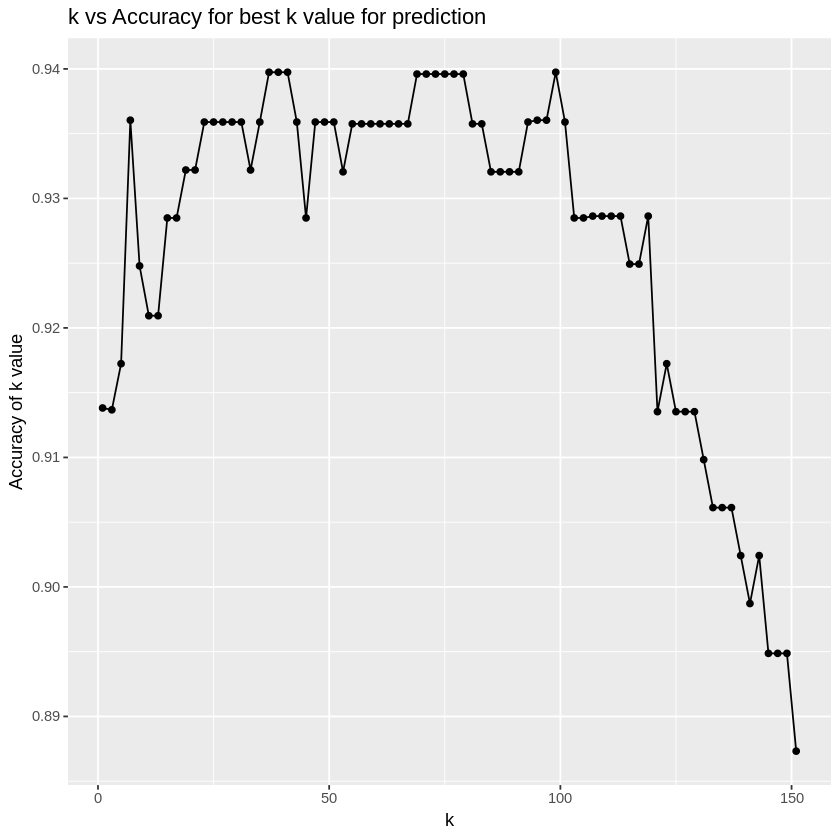

In [41]:
k_accuracies_all <- choose_k_all$results
head(k_accuracies_all)

#options(repr.plot.width = 5)
cross_val_plot_all <- k_accuracies_all %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_all

In [42]:
set.seed(4321)

k_all <- data.frame(k = 99)

knn_class_model_all <- train(x = X_train_all, y = Y_train, method = "knn", tuneGrid = k_all)
knn_class_model_all


k-Nearest Neighbors 

267 samples
  6 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9222668  0.8361476

Tuning parameter 'k' was held constant at a value of 99

In [43]:
test_pred_all <- predict(object = knn_class_model_all, X_test_all)
print(test_pred_all)

confusionMatrix(test_pred_all, Y_test)

modelvalues_all <- data.frame(obs = Y_test, pred = test_pred_all)
test_results_all <- defaultSummary(modelvalues_all)
test_results_all

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9250712  0.8378421
    3  0.9138177  0.8127046
    5  0.9284900  0.8487165
    7  0.9321937  0.8571585
    9  0.9360399  0.8651282
   11  0.9321937  0.8571585
   13  0.9321937  0.8571585
   15  0.9323362  0.8566863
   17  0.9360399  0.8651282
   19  0.9398860  0.8722645
   21  0.9360399  0.8651282
   23  0.9321937  0.8571585
   25  0.9360399  0.8651282
   27  0.9321937  0.8571585
   29  0.9321937  0.8571585
   31  0.9321937  0.8571585
   33  0.9360399  0.8651282
   35  0.9360399  0.8651282
   37  0.9360399  0.8651282
   39  0.9360399  0.8651282
   41  0.9360399  0.8651282
   43  0.9360399  0.8651282
   45  0.9360399  0.8651282
   47  0.9397436  0.8735845
   49  0.9360399  0.8658103
   51  0.9360399  0.8658103
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9250712,0.8378421,0.05307614,0.11372522
3,0.9138177,0.8127046,0.03970616,0.08897461
5,0.9284900,0.8487165,0.05248493,0.10633807
7,0.9321937,0.8571585,0.05065478,0.10146573
9,0.9360399,0.8651282,0.05134115,0.10287031
11,0.9321937,0.8571585,0.05065478,0.10146573


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy  Kappa    
  0.922942  0.8342336

Tuning parameter 'k' was held constant at a value of 19

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

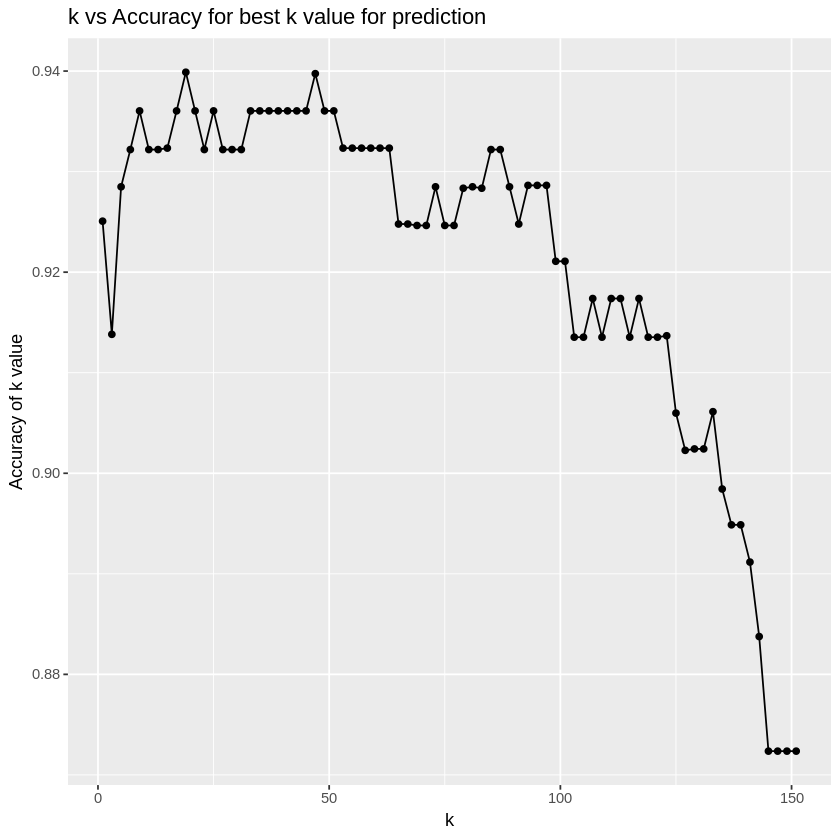

In [44]:
set.seed(4321)
X_train_bu_hemo_pcv_sc_sod <- kidney_scaled_training %>%
    select(bu, hemo, pcv, sc, sod) %>%
    data.frame()

X_test_bu_hemo_pcv_sc_sod <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, sc, sod) %>%
    data.frame()

choose_k_bu_hemo_pcv_sc_sod <- train(x = X_train_bu_hemo_pcv_sc_sod, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_pcv_sc_sod

k_accuracies_bu_hemo_pcv_sc_sod <- choose_k_bu_hemo_pcv_sc_sod$results
head(k_accuracies_bu_hemo_pcv_sc_sod)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_pcv_sc_sod <- k_accuracies_bu_hemo_pcv_sc_sod %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_pcv_sc_sod

set.seed(4321)

k_bu_hemo_pcv_sc_sod <- data.frame(k = 19)

knn_class_model_bu_hemo_pcv_sc_sod <- train(x = X_train_bu_hemo_pcv_sc_sod, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_pcv_sc_sod)
knn_class_model_bu_hemo_pcv_sc_sod


test_pred_bu_hemo_pcv_sc_sod <- predict(object = knn_class_model_bu_hemo_pcv_sc_sod, X_test_bu_hemo_pcv_sc_sod)
print(test_pred_bu_hemo_pcv_sc_sod)

confusionMatrix(test_pred_bu_hemo_pcv_sc_sod, Y_test)

modelvalues_bu_hemo_pcv_sc_sod <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_pcv_sc_sod)
test_results_bu_hemo_pcv_sc_sod <- defaultSummary(modelvalues_bu_hemo_pcv_sc_sod)
test_results_bu_hemo_pcv_sc_sod

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9136752  0.8156247
    3  0.9210826  0.8297664
    5  0.9209402  0.8314826
    7  0.9283476  0.8469874
    9  0.9207977  0.8317614
   11  0.9132479  0.8153474
   13  0.9247863  0.8387050
   15  0.9284900  0.8471613
   17  0.9284900  0.8471613
   19  0.9321937  0.8559888
   21  0.9321937  0.8559888
   23  0.9284900  0.8471613
   25  0.9321937  0.8559888
   27  0.9358974  0.8644307
   29  0.9358974  0.8644307
   31  0.9284900  0.8475146
   33  0.9321937  0.8556160
   35  0.9358974  0.8644307
   37  0.9396011  0.8728870
   39  0.9321937  0.8563420
   41  0.9321937  0.8563420
   43  0.9321937  0.8563420
   45  0.9284900  0.8478857
   47  0.9358974  0.8644307
   49  0.9358974  0.8644307
   51  0.9358974  0.8644307
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9136752,0.8156247,0.04999619,0.1120262
3,0.9210826,0.8297664,0.05448891,0.1207923
5,0.9209402,0.8314826,0.04941581,0.1015880
7,0.9283476,0.8469874,0.06623906,0.1369589
9,0.9207977,0.8317614,0.05555434,0.1138964
11,0.9132479,0.8153474,0.05452717,0.1119991


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy  Kappa    
  0.919753  0.8311857

Tuning parameter 'k' was held constant at a value of 101

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

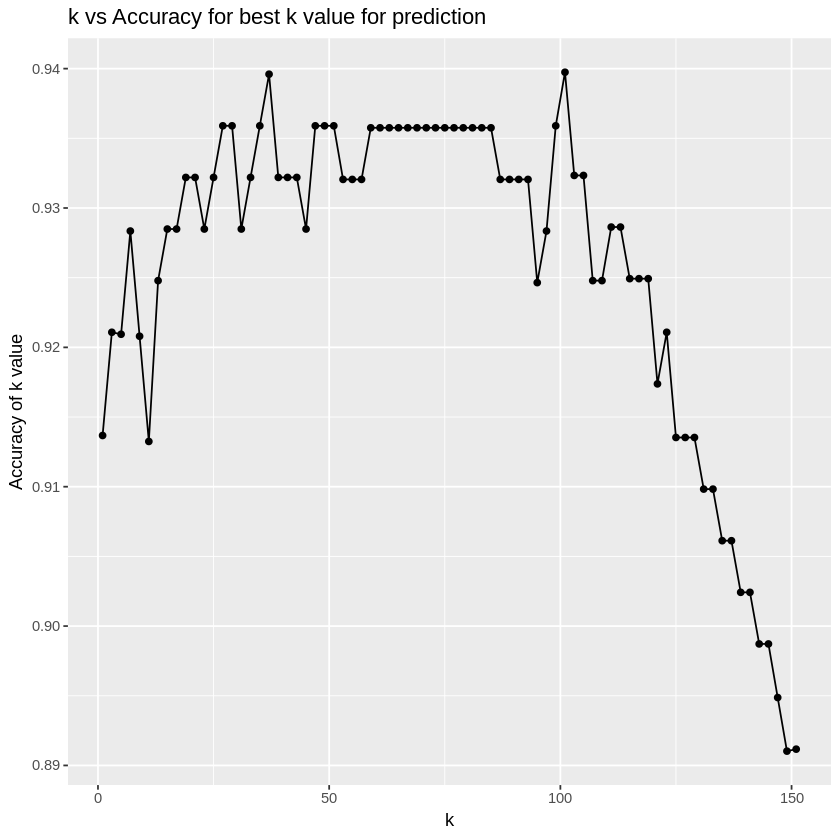

In [45]:
set.seed(4321)
X_train_bu_hemo_pcv_sc_rbcc <- kidney_scaled_training %>%
    select(bu, hemo, pcv, sc, rbcc) %>%
    data.frame()

X_test_bu_hemo_pcv_sc_rbcc <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, sc, rbcc) %>%
    data.frame()

choose_k_bu_hemo_pcv_sc_rbcc <- train(x = X_train_bu_hemo_pcv_sc_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_pcv_sc_rbcc

k_accuracies_bu_hemo_pcv_sc_rbcc <- choose_k_bu_hemo_pcv_sc_rbcc$results
head(k_accuracies_bu_hemo_pcv_sc_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_pcv_sc_rbcc <- k_accuracies_bu_hemo_pcv_sc_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_pcv_sc_rbcc

set.seed(4321)

k_bu_hemo_pcv_sc_rbcc <- data.frame(k = 101)

knn_class_model_bu_hemo_pcv_sc_rbcc <- train(x = X_train_bu_hemo_pcv_sc_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_pcv_sc_rbcc)
knn_class_model_bu_hemo_pcv_sc_rbcc


test_pred_bu_hemo_pcv_sc_rbcc <- predict(object = knn_class_model_bu_hemo_pcv_sc_rbcc, X_test_bu_hemo_pcv_sc_rbcc)
print(test_pred_bu_hemo_pcv_sc_rbcc)

confusionMatrix(test_pred_bu_hemo_pcv_sc_rbcc, Y_test)

modelvalues_bu_hemo_pcv_sc_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_pcv_sc_rbcc)
test_results_bu_hemo_pcv_sc_rbcc <- defaultSummary(modelvalues_bu_hemo_pcv_sc_rbcc)
test_results_bu_hemo_pcv_sc_rbcc

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.8952991  0.7692579
    3  0.8951567  0.7733559
    5  0.9246439  0.8381362
    7  0.9059829  0.7975028
    9  0.9096866  0.8067263
   11  0.9207977  0.8320885
   13  0.9247863  0.8397515
   15  0.9210826  0.8316501
   17  0.9247863  0.8393871
   19  0.9247863  0.8393871
   21  0.9284900  0.8474885
   23  0.9172365  0.8223537
   25  0.9135328  0.8139117
   27  0.9135328  0.8142456
   29  0.9135328  0.8142456
   31  0.9098291  0.8057893
   33  0.9172365  0.8223537
   35  0.9135328  0.8142456
   37  0.9172365  0.8226875
   39  0.9135328  0.8142456
   41  0.9172365  0.8226875
   43  0.9172365  0.8226875
   45  0.9209402  0.8307957
   47  0.9209402  0.8307889
   49  0.9209402  0.8307957
   51  0.9210826  0.8305168
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.8952991,0.7692579,0.07203481,0.16335432
3,0.8951567,0.7733559,0.03885638,0.08664927
5,0.9246439,0.8381362,0.04761828,0.10208256
7,0.9059829,0.7975028,0.05729967,0.12256050
9,0.9096866,0.8067263,0.05454268,0.11369837
11,0.9207977,0.8320885,0.05555434,0.11417885


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9166194  0.8244332

Tuning parameter 'k' was held constant at a value of 113

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

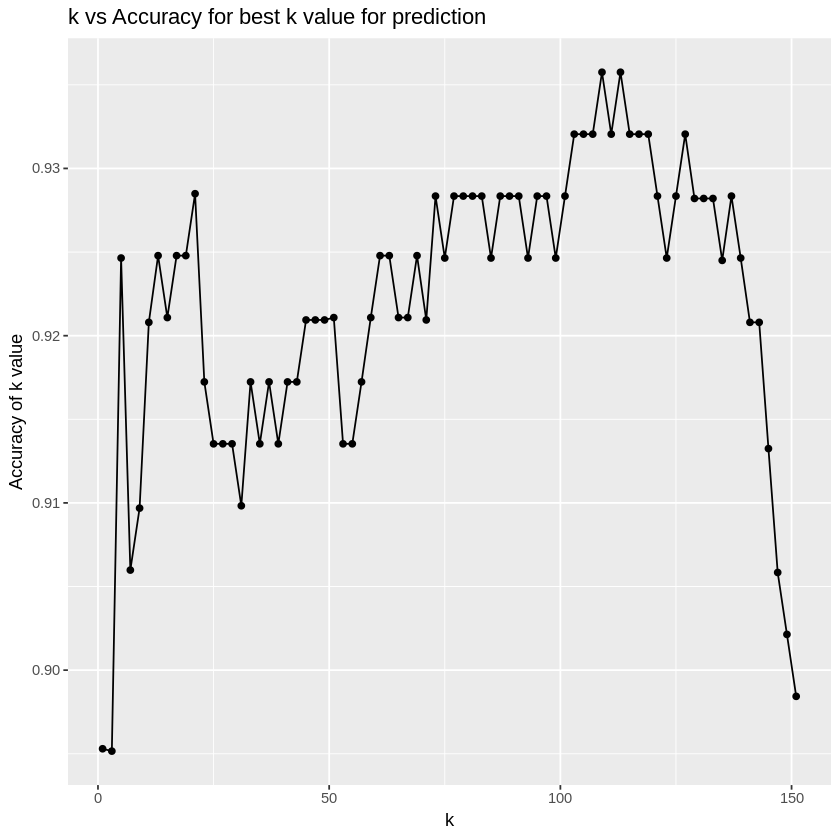

In [46]:
set.seed(4321)
X_train_bu_hemo_pcv_sod_rbcc <- kidney_scaled_training %>%
    select(bu, hemo, pcv, sod, rbcc) %>%
    data.frame()

X_test_bu_hemo_pcv_sod_rbcc <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, sod, rbcc) %>%
    data.frame()

choose_k_bu_hemo_pcv_sod_rbcc <- train(x = X_train_bu_hemo_pcv_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_pcv_sod_rbcc

k_accuracies_bu_hemo_pcv_sod_rbcc <- choose_k_bu_hemo_pcv_sod_rbcc$results
head(k_accuracies_bu_hemo_pcv_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_pcv_sod_rbcc <- k_accuracies_bu_hemo_pcv_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_pcv_sod_rbcc

set.seed(4321)

k_bu_hemo_pcv_sod_rbcc <- data.frame(k = 113)

knn_class_model_bu_hemo_pcv_sod_rbcc <- train(x = X_train_bu_hemo_pcv_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_pcv_sod_rbcc)
knn_class_model_bu_hemo_pcv_sod_rbcc


test_pred_bu_hemo_pcv_sod_rbcc <- predict(object = knn_class_model_bu_hemo_pcv_sod_rbcc, X_test_bu_hemo_pcv_sod_rbcc)
print(test_pred_bu_hemo_pcv_sod_rbcc)

confusionMatrix(test_pred_bu_hemo_pcv_sod_rbcc, Y_test)

modelvalues_bu_hemo_pcv_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_pcv_sod_rbcc)
test_results_bu_hemo_pcv_sod_rbcc <- defaultSummary(modelvalues_bu_hemo_pcv_sod_rbcc)
test_results_bu_hemo_pcv_sod_rbcc

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9249288  0.8386357
    3  0.9361823  0.8613985
    5  0.9321937  0.8571401
    7  0.9286325  0.8480744
    9  0.9360399  0.8649255
   11  0.9360399  0.8642906
   13  0.9360399  0.8642906
   15  0.9323362  0.8554861
   17  0.9323362  0.8560371
   19  0.9323362  0.8560371
   21  0.9323362  0.8560371
   23  0.9360399  0.8648416
   25  0.9284900  0.8474342
   27  0.9284900  0.8474342
   29  0.9284900  0.8474342
   31  0.9284900  0.8474342
   33  0.9207977  0.8302150
   35  0.9209402  0.8303814
   37  0.9209402  0.8303814
   39  0.9284900  0.8481306
   41  0.9323362  0.8552669
   43  0.9324786  0.8550652
   45  0.9284900  0.8463222
   47  0.9323362  0.8545637
   49  0.9323362  0.8552669
   51  0.9286325  0.8464623
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9249288,0.8386357,0.03545740,0.07742304
3,0.9361823,0.8613985,0.04348710,0.09871382
5,0.9321937,0.8571401,0.05065478,0.10146812
7,0.9286325,0.8480744,0.04538800,0.09534028
9,0.9360399,0.8649255,0.04753298,0.09900507
11,0.9360399,0.8642906,0.04421032,0.09180795


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9238647  0.8354547

Tuning parameter 'k' was held constant at a value of 63

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

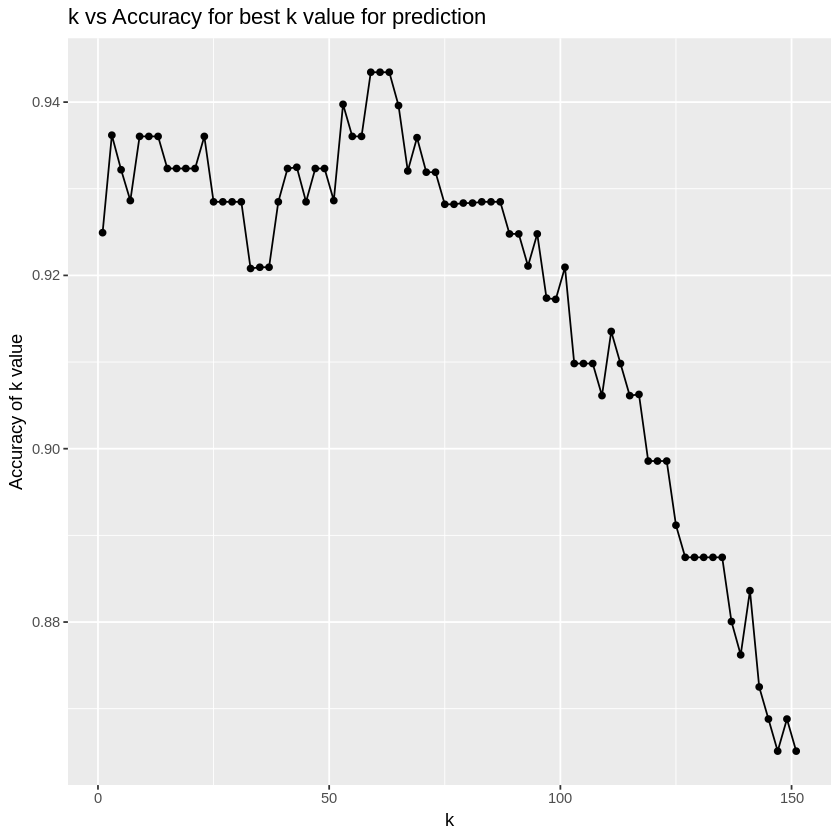

In [47]:
set.seed(4321)
X_train_bu_hemo_sc_sod_rbcc <- kidney_scaled_training %>%
    select(bu, hemo, sc, sod, rbcc) %>%
    data.frame()

X_test_bu_hemo_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(bu, hemo, sc, sod, rbcc) %>%
    data.frame()

choose_k_bu_hemo_sc_sod_rbcc <- train(x = X_train_bu_hemo_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_sc_sod_rbcc

k_accuracies_bu_hemo_sc_sod_rbcc <- choose_k_bu_hemo_sc_sod_rbcc$results
head(k_accuracies_bu_hemo_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_sc_sod_rbcc <- k_accuracies_bu_hemo_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_sc_sod_rbcc

set.seed(4321)

k_bu_hemo_sc_sod_rbcc <- data.frame(k = 63)

knn_class_model_bu_hemo_sc_sod_rbcc <- train(x = X_train_bu_hemo_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_sc_sod_rbcc)
knn_class_model_bu_hemo_sc_sod_rbcc


test_pred_bu_hemo_sc_sod_rbcc <- predict(object = knn_class_model_bu_hemo_sc_sod_rbcc, X_test_bu_hemo_sc_sod_rbcc)
print(test_pred_bu_hemo_sc_sod_rbcc)

confusionMatrix(test_pred_bu_hemo_sc_sod_rbcc, Y_test)

modelvalues_bu_hemo_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_sc_sod_rbcc)
test_results_bu_hemo_sc_sod_rbcc <- defaultSummary(modelvalues_bu_hemo_sc_sod_rbcc)
test_results_bu_hemo_sc_sod_rbcc

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.8984330  0.7824901
    3  0.9098291  0.8067583
    5  0.9209402  0.8305818
    7  0.9245014  0.8397918
    9  0.9133903  0.8139162
   11  0.9058405  0.7988052
   13  0.8982906  0.7810943
   15  0.9019943  0.7888542
   17  0.9132479  0.8146538
   19  0.9058405  0.7981231
   21  0.9133903  0.8151387
   23  0.9209402  0.8314911
   25  0.9172365  0.8234024
   27  0.9133903  0.8151387
   29  0.9172365  0.8242615
   31  0.9210826  0.8313722
   33  0.9247863  0.8398285
   35  0.9209402  0.8318587
   37  0.9170940  0.8235950
   39  0.9209402  0.8308387
   41  0.9209402  0.8311327
   43  0.9173789  0.8222243
   45  0.9209402  0.8312098
   47  0.9209402  0.8312443
   49  0.9209402  0.8312443
   51  0.9246439  0.8397007
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.8984330,0.7824901,0.04154755,0.08531289
3,0.9098291,0.8067583,0.04094626,0.09133455
5,0.9209402,0.8305818,0.04570877,0.09832911
7,0.9245014,0.8397918,0.05153642,0.10646087
9,0.9133903,0.8139162,0.04120288,0.08707832
11,0.9058405,0.7988052,0.04922014,0.10145798


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa   
  0.9039013  0.794394

Tuning parameter 'k' was held constant at a value of 75

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd ckd    notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd ckd    notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      2
    notckd   1     42
                                         
               Accuracy : 0.9583         
                 95% CI : (0.883, 0.9913)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 6.559e-12      
                                         
                  Kappa : 0.9129         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 0.9545         
         Pos Pred Value : 0.9310         
         Neg Pred Value : 0.9767         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.4028         
      Balanced Accuracy : 0.9594         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9583333 0.9129032

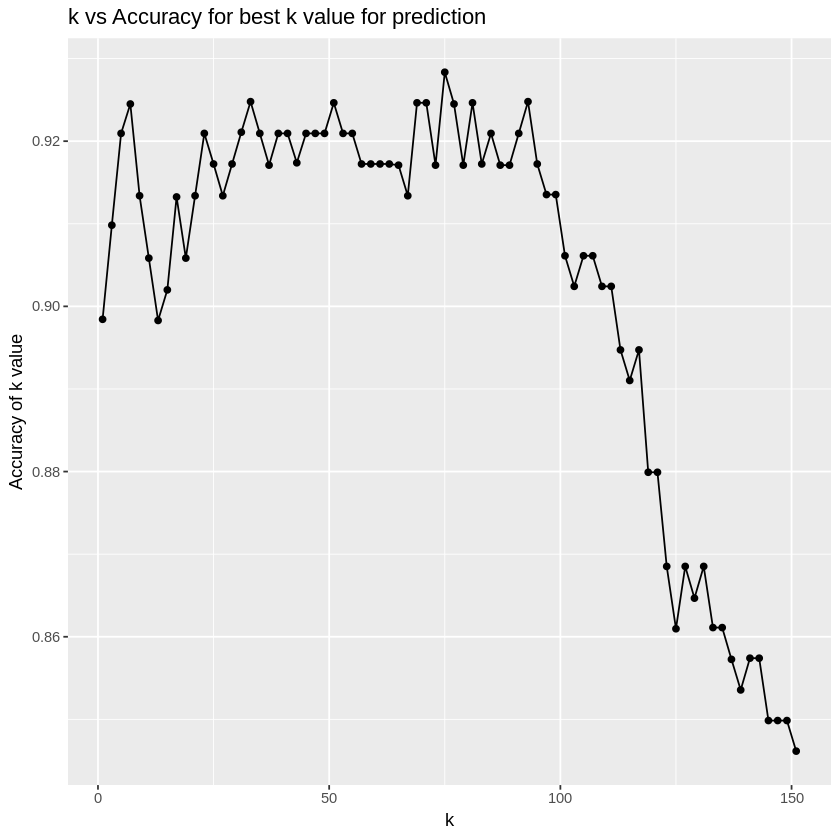

In [48]:
set.seed(4321)
X_train_bu_pcv_sc_sod_rbcc <- kidney_scaled_training %>%
    select(bu, pcv, sc, sod, rbcc) %>%
    data.frame()

X_test_bu_pcv_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(bu, pcv, sc, sod, rbcc) %>%
    data.frame()

choose_k_bu_pcv_sc_sod_rbcc <- train(x = X_train_bu_pcv_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_pcv_sc_sod_rbcc

k_accuracies_bu_pcv_sc_sod_rbcc <- choose_k_bu_pcv_sc_sod_rbcc$results
head(k_accuracies_bu_pcv_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_pcv_sc_sod_rbcc <- k_accuracies_bu_pcv_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_pcv_sc_sod_rbcc

set.seed(4321)

k_bu_pcv_sc_sod_rbcc <- data.frame(k = 75)

knn_class_model_bu_pcv_sc_sod_rbcc <- train(x = X_train_bu_pcv_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_pcv_sc_sod_rbcc)
knn_class_model_bu_pcv_sc_sod_rbcc


test_pred_bu_pcv_sc_sod_rbcc <- predict(object = knn_class_model_bu_pcv_sc_sod_rbcc, X_test_bu_pcv_sc_sod_rbcc)
print(test_pred_bu_pcv_sc_sod_rbcc)

confusionMatrix(test_pred_bu_pcv_sc_sod_rbcc, Y_test)

modelvalues_bu_pcv_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_pcv_sc_sod_rbcc)
test_results_bu_pcv_sc_sod_rbcc <- defaultSummary(modelvalues_bu_pcv_sc_sod_rbcc)
test_results_bu_pcv_sc_sod_rbcc

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9289174  0.8483797
    3  0.9135328  0.8153577
    5  0.9284900  0.8482128
    7  0.9320513  0.8582758
    9  0.9320513  0.8582758
   11  0.9357550  0.8663839
   13  0.9396011  0.8743537
   15  0.9357550  0.8657508
   17  0.9357550  0.8657508
   19  0.9396011  0.8728870
   21  0.9396011  0.8728870
   23  0.9396011  0.8728870
   25  0.9396011  0.8728870
   27  0.9396011  0.8728870
   29  0.9396011  0.8728870
   31  0.9396011  0.8728870
   33  0.9396011  0.8728870
   35  0.9396011  0.8728870
   37  0.9396011  0.8728870
   39  0.9396011  0.8728870
   41  0.9396011  0.8728870
   43  0.9357550  0.8639423
   45  0.9396011  0.8728870
   47  0.9396011  0.8728870
   49  0.9396011  0.8728870
   51  0.9396011  0.8728870
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9289174,0.8483797,0.04099799,0.08865383
3,0.9135328,0.8153577,0.04384467,0.09533974
5,0.9284900,0.8482128,0.03825758,0.07871125
7,0.9320513,0.8582758,0.04770154,0.09360357
9,0.9320513,0.8582758,0.04770154,0.09360357
11,0.9357550,0.8663839,0.05164328,0.10252664


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9319147  0.8559545

Tuning parameter 'k' was held constant at a value of 151

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

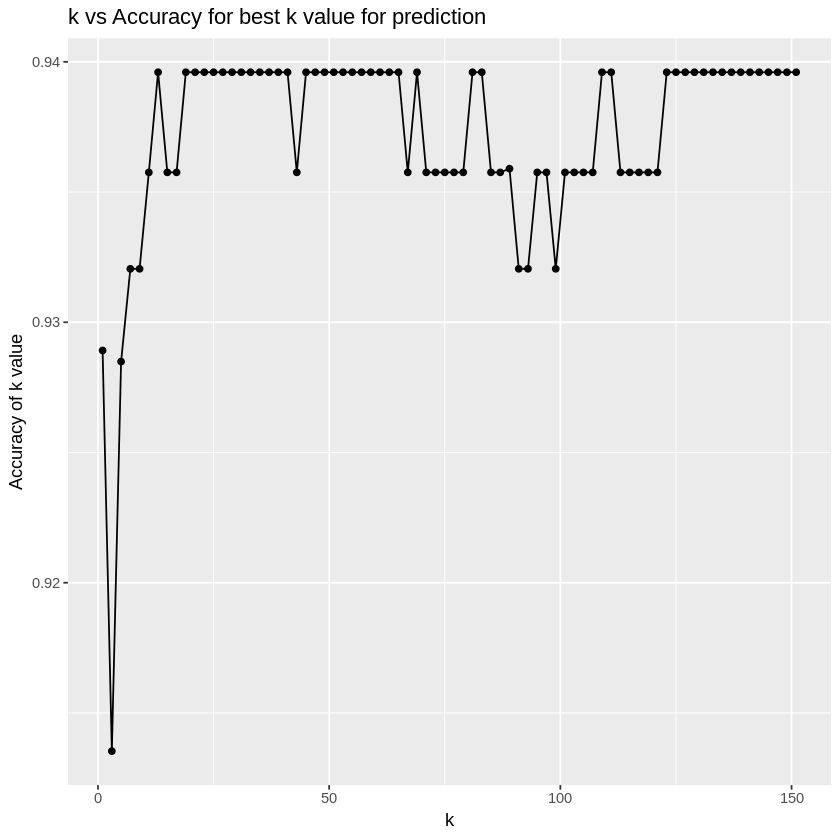

In [49]:
set.seed(4321)
X_train_hemo_pcv_sc_sod_rbcc <- kidney_scaled_training %>%
    select(hemo, pcv, sc, sod, rbcc) %>%
    data.frame()

X_test_hemo_pcv_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(hemo, pcv, sc, sod, rbcc) %>%
    data.frame()

choose_k_hemo_pcv_sc_sod_rbcc <- train(x = X_train_hemo_pcv_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_hemo_pcv_sc_sod_rbcc

k_accuracies_hemo_pcv_sc_sod_rbcc <- choose_k_hemo_pcv_sc_sod_rbcc$results
head(k_accuracies_hemo_pcv_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_hemo_pcv_sc_sod_rbcc <- k_accuracies_hemo_pcv_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_hemo_pcv_sc_sod_rbcc

set.seed(4321)

k_hemo_pcv_sc_sod_rbcc <- data.frame(k = 151)

knn_class_model_hemo_pcv_sc_sod_rbcc <- train(x = X_train_hemo_pcv_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_hemo_pcv_sc_sod_rbcc)
knn_class_model_hemo_pcv_sc_sod_rbcc


test_pred_hemo_pcv_sc_sod_rbcc <- predict(object = knn_class_model_hemo_pcv_sc_sod_rbcc, X_test_hemo_pcv_sc_sod_rbcc)
print(test_pred_hemo_pcv_sc_sod_rbcc)

confusionMatrix(test_pred_hemo_pcv_sc_sod_rbcc, Y_test)

modelvalues_hemo_pcv_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_hemo_pcv_sc_sod_rbcc)
test_results_hemo_pcv_sc_sod_rbcc <- defaultSummary(modelvalues_hemo_pcv_sc_sod_rbcc)
test_results_hemo_pcv_sc_sod_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9138177  0.8153174
    3  0.9135328  0.8137984
    5  0.9284900  0.8480201
    7  0.9321937  0.8571585
    9  0.9321937  0.8571585
   11  0.9321937  0.8571585
   13  0.9321937  0.8571585
   15  0.9321937  0.8571585
   17  0.9284900  0.8487165
   19  0.9321937  0.8571585
   21  0.9360399  0.8642947
   23  0.9321937  0.8571585
   25  0.9321937  0.8571585
   27  0.9321937  0.8571585
   29  0.9321937  0.8571585
   31  0.9321937  0.8571585
   33  0.9360399  0.8651282
   35  0.9360399  0.8651282
   37  0.9323362  0.8573683
   39  0.9286325  0.8495941
   41  0.9323362  0.8573540
   43  0.9321937  0.8571585
   45  0.9321937  0.8571585
   47  0.9360399  0.8658103
   49  0.9323362  0.8583497
   51  0.9323362  0.8583497
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9138177,0.8153174,0.05896836,0.1247176
3,0.9135328,0.8137984,0.05055609,0.1123385
5,0.9284900,0.8480201,0.06057361,0.1263455
7,0.9321937,0.8571585,0.05065478,0.1014657
9,0.9321937,0.8571585,0.05065478,0.1014657
11,0.9321937,0.8571585,0.05065478,0.1014657


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9235229  0.8371294

Tuning parameter 'k' was held constant at a value of 47

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

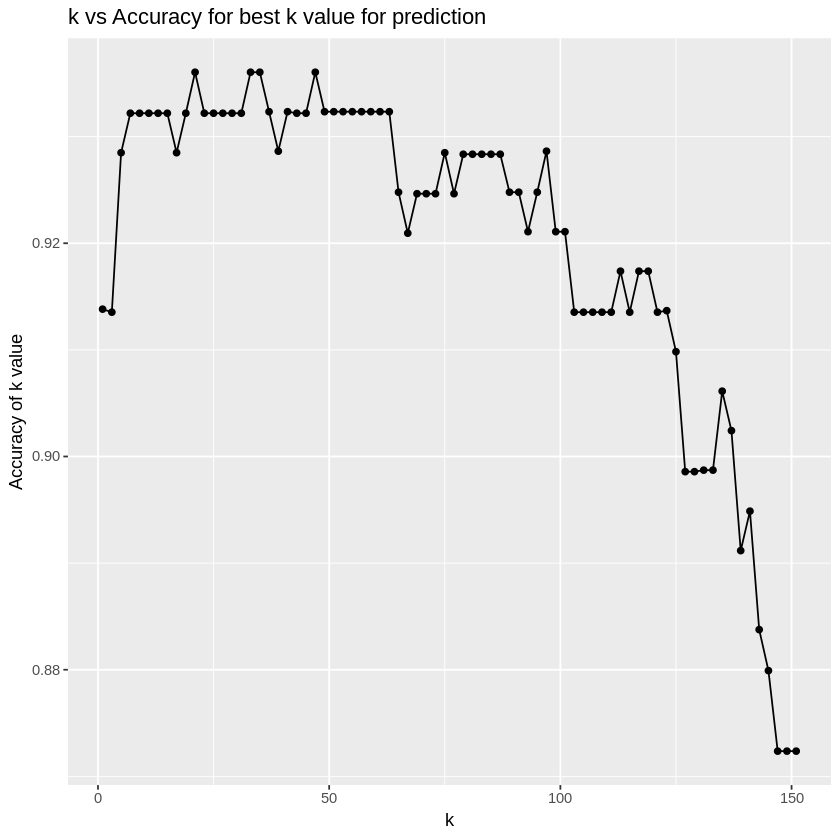

In [50]:
set.seed(4321)
X_train_bu_hemo_pcv_sc <- kidney_scaled_training %>%
    select(bu, hemo, pcv, sc) %>%
    data.frame()

X_test_bu_hemo_pcv_sc <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, sc) %>%
    data.frame()

choose_k_bu_hemo_pcv_sc <- train(x = X_train_bu_hemo_pcv_sc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_pcv_sc

k_accuracies_bu_hemo_pcv_sc <- choose_k_bu_hemo_pcv_sc$results
head(k_accuracies_bu_hemo_pcv_sc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_pcv_sc <- k_accuracies_bu_hemo_pcv_sc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_pcv_sc

set.seed(4321)

k_bu_hemo_pcv_sc <- data.frame(k = 47)

knn_class_model_bu_hemo_pcv_sc <- train(x = X_train_bu_hemo_pcv_sc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_pcv_sc)
knn_class_model_bu_hemo_pcv_sc


test_pred_bu_hemo_pcv_sc <- predict(object = knn_class_model_bu_hemo_pcv_sc, X_test_bu_hemo_pcv_sc)
print(test_pred_bu_hemo_pcv_sc)

confusionMatrix(test_pred_bu_hemo_pcv_sc, Y_test)

modelvalues_bu_hemo_pcv_sc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_pcv_sc)
test_results_bu_hemo_pcv_sc <- defaultSummary(modelvalues_bu_hemo_pcv_sc)
test_results_bu_hemo_pcv_sc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9065527  0.7978783
    3  0.9099715  0.8091829
    5  0.9210826  0.8313035
    7  0.9135328  0.8170389
    9  0.9170940  0.8253464
   11  0.9283476  0.8498617
   13  0.9209402  0.8333167
   15  0.9209402  0.8333167
   17  0.9172365  0.8261512
   19  0.9209402  0.8333167
   21  0.9247863  0.8404529
   23  0.9247863  0.8404529
   25  0.9249288  0.8406340
   27  0.9210826  0.8316484
   29  0.9247863  0.8408520
   31  0.9210826  0.8324101
   33  0.9210826  0.8309434
   35  0.9173789  0.8225217
   37  0.9210826  0.8309434
   39  0.9247863  0.8393854
   41  0.9286325  0.8479883
   43  0.9286325  0.8479883
   45  0.9247863  0.8412577
   47  0.9284900  0.8497140
   49  0.9286325  0.8497101
   51  0.9210826  0.8330058
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9065527,0.7978783,0.04981548,0.10497162
3,0.9099715,0.8091829,0.04056315,0.08319055
5,0.9210826,0.8313035,0.03769594,0.08040288
7,0.9135328,0.8170389,0.05102663,0.10579609
9,0.9170940,0.8253464,0.05071083,0.10301401
11,0.9283476,0.8498617,0.05261043,0.10640280


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9078092  0.8082534

Tuning parameter 'k' was held constant at a value of 123

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

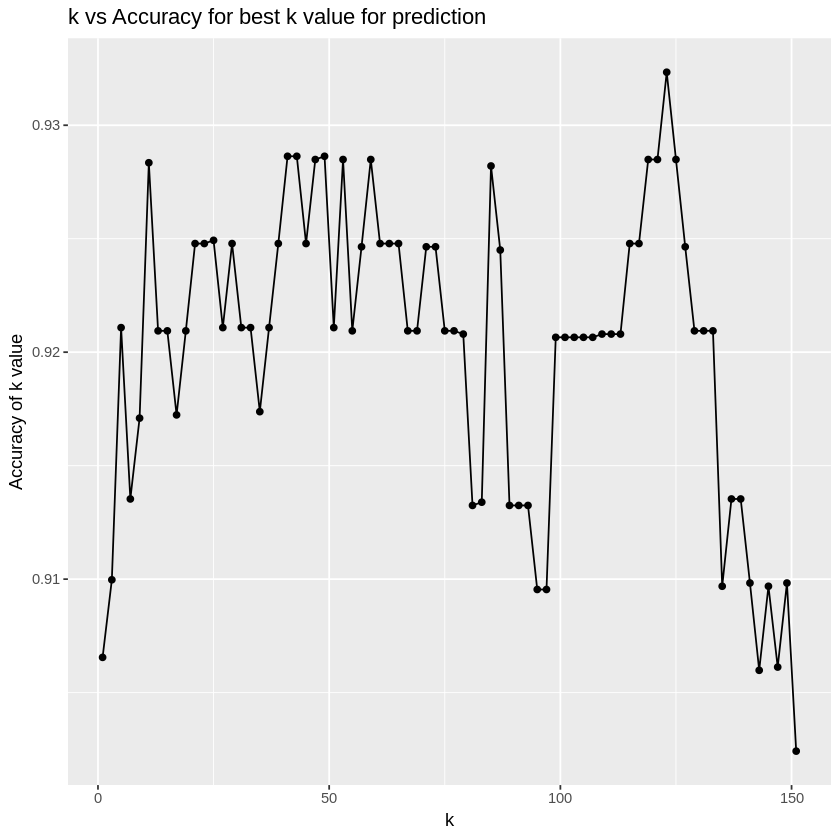

In [51]:
set.seed(4321)
X_train_bu_hemo_pcv_sod <- kidney_scaled_training %>%
    select(bu, hemo, pcv, sod) %>%
    data.frame()

X_test_bu_hemo_pcv_sod <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, sod) %>%
    data.frame()

choose_k_bu_hemo_pcv_sod <- train(x = X_train_bu_hemo_pcv_sod, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_pcv_sod

k_accuracies_bu_hemo_pcv_sod <- choose_k_bu_hemo_pcv_sod$results
head(k_accuracies_bu_hemo_pcv_sod)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_pcv_sod <- k_accuracies_bu_hemo_pcv_sod %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_pcv_sod

set.seed(4321)

k_bu_hemo_pcv_sod <- data.frame(k = 123)

knn_class_model_bu_hemo_pcv_sod <- train(x = X_train_bu_hemo_pcv_sod, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_pcv_sod)
knn_class_model_bu_hemo_pcv_sod


test_pred_bu_hemo_pcv_sod <- predict(object = knn_class_model_bu_hemo_pcv_sod, X_test_bu_hemo_pcv_sod)
print(test_pred_bu_hemo_pcv_sod)

confusionMatrix(test_pred_bu_hemo_pcv_sod, Y_test)

modelvalues_bu_hemo_pcv_sod <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_pcv_sod)
test_results_bu_hemo_pcv_sod <- defaultSummary(modelvalues_bu_hemo_pcv_sod)
test_results_bu_hemo_pcv_sod

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.8915954  0.7621170
    3  0.8913105  0.7655004
    5  0.9210826  0.8312157
    7  0.9207977  0.8317470
    9  0.9207977  0.8324291
   11  0.9170940  0.8239998
   13  0.9172365  0.8245265
   15  0.9247863  0.8397515
   17  0.9210826  0.8312984
   19  0.9247863  0.8393871
   21  0.9210826  0.8312984
   23  0.9210826  0.8312984
   25  0.9098291  0.8046882
   27  0.9098291  0.8057893
   29  0.9098291  0.8057893
   31  0.9098291  0.8057893
   33  0.9135328  0.8142456
   35  0.9135328  0.8142456
   37  0.9098291  0.8058036
   39  0.9172365  0.8226875
   41  0.9172365  0.8226875
   43  0.9172365  0.8226875
   45  0.9172365  0.8226875
   47  0.9247863  0.8397336
   49  0.9247863  0.8386182
   51  0.9173789  0.8220748
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.8915954,0.7621170,0.04727614,0.11161323
3,0.8913105,0.7655004,0.03302093,0.07197987
5,0.9210826,0.8312157,0.03376466,0.07044091
7,0.9207977,0.8317470,0.05273948,0.10730261
9,0.9207977,0.8324291,0.05273948,0.10734271
11,0.9170940,0.8239998,0.05640258,0.11582237


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9157048  0.8224216

Tuning parameter 'k' was held constant at a value of 113

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

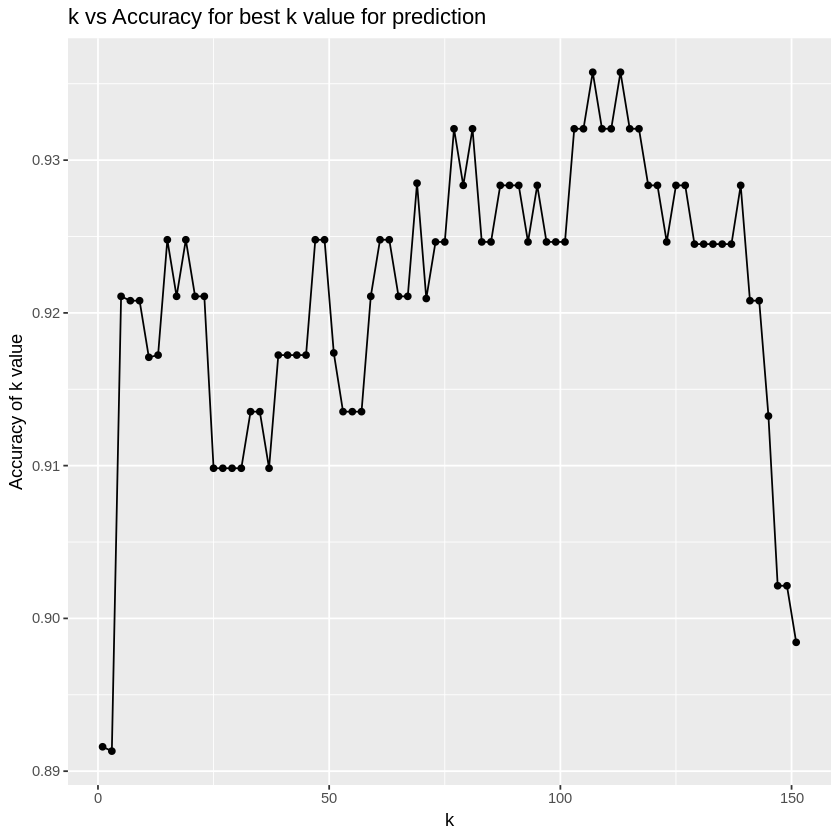

In [52]:
set.seed(4321)
X_train_bu_hemo_pcv_rbcc <- kidney_scaled_training %>%
    select(bu, hemo, pcv, rbcc) %>%
    data.frame()

X_test_bu_hemo_pcv_rbcc <- kidney_scaled_testing %>%
    select(bu, hemo, pcv, rbcc) %>%
    data.frame()

choose_k_bu_hemo_pcv_rbcc <- train(x = X_train_bu_hemo_pcv_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_pcv_rbcc

k_accuracies_bu_hemo_pcv_rbcc <- choose_k_bu_hemo_pcv_rbcc$results
head(k_accuracies_bu_hemo_pcv_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_pcv_rbcc <- k_accuracies_bu_hemo_pcv_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_pcv_rbcc

set.seed(4321)

k_bu_hemo_pcv_rbcc <- data.frame(k = 113)

knn_class_model_bu_hemo_pcv_rbcc <- train(x = X_train_bu_hemo_pcv_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_pcv_rbcc)
knn_class_model_bu_hemo_pcv_rbcc


test_pred_bu_hemo_pcv_rbcc <- predict(object = knn_class_model_bu_hemo_pcv_rbcc, X_test_bu_hemo_pcv_rbcc)
print(test_pred_bu_hemo_pcv_rbcc)

confusionMatrix(test_pred_bu_hemo_pcv_rbcc, Y_test)

modelvalues_bu_hemo_pcv_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_pcv_rbcc)
test_results_bu_hemo_pcv_rbcc <- defaultSummary(modelvalues_bu_hemo_pcv_rbcc)
test_results_bu_hemo_pcv_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9438746  0.8761279
    3  0.9136752  0.8153823
    5  0.9249288  0.8407666
    7  0.9209402  0.8327125
    9  0.9284900  0.8500663
   11  0.9284900  0.8490976
   13  0.9360399  0.8658103
   15  0.9360399  0.8658103
   17  0.9323362  0.8573540
   19  0.9321937  0.8568575
   21  0.9360399  0.8648272
   23  0.9286325  0.8492526
   25  0.9286325  0.8492526
   27  0.9286325  0.8492526
   29  0.9286325  0.8492526
   31  0.9286325  0.8492526
   33  0.9249288  0.8414927
   35  0.9249288  0.8414927
   37  0.9249288  0.8414927
   39  0.9286325  0.8492526
   41  0.9212251  0.8340321
   43  0.9286325  0.8489660
   45  0.9249288  0.8414927
   47  0.9249288  0.8414927
   49  0.9286325  0.8489660
   51  0.9324786  0.8571949
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9438746,0.8761279,0.05039595,0.11370789
3,0.9136752,0.8153823,0.06510662,0.13432487
5,0.9249288,0.8407666,0.05385984,0.11105989
7,0.9209402,0.8327125,0.06129312,0.12612846
9,0.9284900,0.8500663,0.04949582,0.09906855
11,0.9284900,0.8490976,0.05248493,0.10653351


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9385898  0.8661702

Tuning parameter 'k' was held constant at a value of 1

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd ckd    notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd ckd    notckd notckd notckd ckd    notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      3
    notckd   1     41
                                          
               Accuracy : 0.9444          
                 95% CI : (0.8638, 0.9847)
    No Information Rate : 0.6111          
    P-Value [Acc > NIR] : 7.383e-11       
                                          
                  Kappa : 0.8846          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9643          
            Specificity : 0.9318          
         Pos Pred Value : 0.9000          
         Neg Pred Value : 0.9762          
             Prevalence : 0.3889          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.4167          
      Balanced Accuracy : 0.9481          
                                          
       'Positive' Class : ckd             
                                          

Accuracy     Kappa 
0.9444444 0.8846154

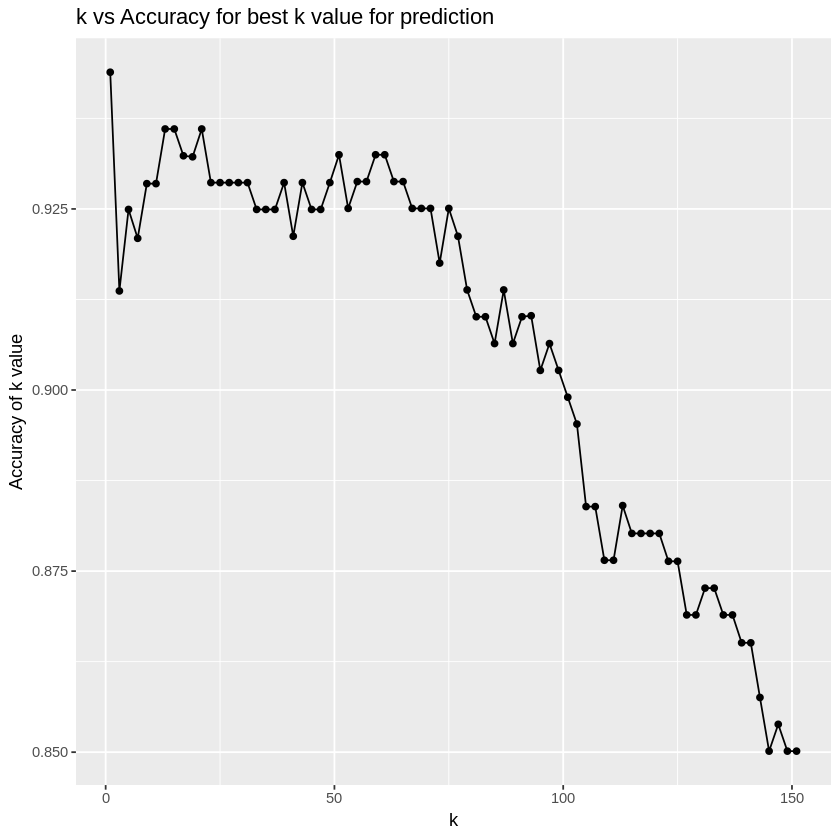

In [53]:
set.seed(4321)
X_train_bu_hemo_sc_sod <- kidney_scaled_training %>%
    select(bu, hemo, sc, sod) %>%
    data.frame()

X_test_bu_hemo_sc_sod <- kidney_scaled_testing %>%
    select(bu, hemo, sc, sod) %>%
    data.frame()

choose_k_bu_hemo_sc_sod <- train(x = X_train_bu_hemo_sc_sod, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_sc_sod

k_accuracies_bu_hemo_sc_sod <- choose_k_bu_hemo_sc_sod$results
head(k_accuracies_bu_hemo_sc_sod)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_sc_sod <- k_accuracies_bu_hemo_sc_sod %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_sc_sod

set.seed(4321)

k_bu_hemo_sc_sod <- data.frame(k = 1)

knn_class_model_bu_hemo_sc_sod <- train(x = X_train_bu_hemo_sc_sod, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_sc_sod)
knn_class_model_bu_hemo_sc_sod


test_pred_bu_hemo_sc_sod <- predict(object = knn_class_model_bu_hemo_sc_sod, X_test_bu_hemo_sc_sod)
print(test_pred_bu_hemo_sc_sod)

confusionMatrix(test_pred_bu_hemo_sc_sod, Y_test)

modelvalues_bu_hemo_sc_sod <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_sc_sod)
test_results_bu_hemo_sc_sod <- defaultSummary(modelvalues_bu_hemo_sc_sod)
test_results_bu_hemo_sc_sod

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9323362  0.8552779
    3  0.9212251  0.8296542
    5  0.9246439  0.8423791
    7  0.9321937  0.8584502
    9  0.9360399  0.8655865
   11  0.9284900  0.8503489
   13  0.9284900  0.8503489
   15  0.9284900  0.8483499
   17  0.9284900  0.8483499
   19  0.9323362  0.8560371
   21  0.9323362  0.8560371
   23  0.9323362  0.8560371
   25  0.9321937  0.8562387
   27  0.9246439  0.8384895
   29  0.9209402  0.8303814
   31  0.9246439  0.8384895
   33  0.9209402  0.8303881
   35  0.9246439  0.8384895
   37  0.9209402  0.8303814
   39  0.9246439  0.8391859
   41  0.9246439  0.8404434
   43  0.9286325  0.8479290
   45  0.9284900  0.8463222
   47  0.9360399  0.8633750
   49  0.9397436  0.8714763
   51  0.9398860  0.8712747
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9323362,0.8552779,0.04612125,0.10018671
3,0.9212251,0.8296542,0.05151039,0.11492760
5,0.9246439,0.8423791,0.04811756,0.09595135
7,0.9321937,0.8584502,0.05065478,0.10122554
9,0.9360399,0.8655865,0.04061675,0.08307382
11,0.9284900,0.8503489,0.04949582,0.09876952


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9238243  0.8354434

Tuning parameter 'k' was held constant at a value of 61

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

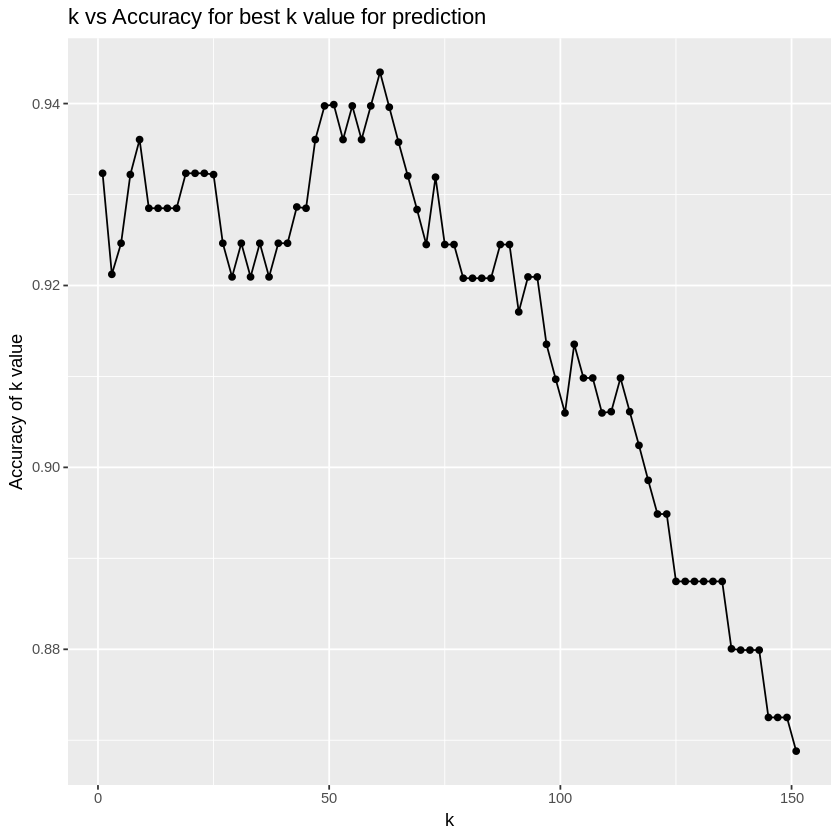

In [54]:
set.seed(4321)
X_train_bu_hemo_sc_rbcc <- kidney_scaled_training %>%
    select(bu, hemo, sc, rbcc) %>%
    data.frame()

X_test_bu_hemo_sc_rbcc <- kidney_scaled_testing %>%
    select(bu, hemo, sc, rbcc) %>%
    data.frame()

choose_k_bu_hemo_sc_rbcc <- train(x = X_train_bu_hemo_sc_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_sc_rbcc

k_accuracies_bu_hemo_sc_rbcc <- choose_k_bu_hemo_sc_rbcc$results
head(k_accuracies_bu_hemo_sc_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_sc_rbcc <- k_accuracies_bu_hemo_sc_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_sc_rbcc

set.seed(4321)

k_bu_hemo_sc_rbcc <- data.frame(k = 61)

knn_class_model_bu_hemo_sc_rbcc <- train(x = X_train_bu_hemo_sc_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_sc_rbcc)
knn_class_model_bu_hemo_sc_rbcc


test_pred_bu_hemo_sc_rbcc <- predict(object = knn_class_model_bu_hemo_sc_rbcc, X_test_bu_hemo_sc_rbcc)
print(test_pred_bu_hemo_sc_rbcc)

confusionMatrix(test_pred_bu_hemo_sc_rbcc, Y_test)

modelvalues_bu_hemo_sc_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_sc_rbcc)
test_results_bu_hemo_sc_rbcc <- defaultSummary(modelvalues_bu_hemo_sc_rbcc)
test_results_bu_hemo_sc_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9213675  0.8291518
    3  0.8836182  0.7498350
    5  0.9099715  0.8072498
    7  0.9212251  0.8321448
    9  0.9173789  0.8260389
   11  0.9247863  0.8398496
   13  0.9209402  0.8312467
   15  0.9210826  0.8299172
   17  0.9096866  0.8013195
   19  0.9061254  0.7950522
   21  0.9061254  0.7950522
   23  0.8948718  0.7695985
   25  0.8910256  0.7603661
   27  0.8871795  0.7528328
   29  0.8908832  0.7620124
   31  0.8871795  0.7535704
   33  0.8873219  0.7522647
   35  0.8834758  0.7451285
   37  0.8910256  0.7607067
   39  0.8910256  0.7607067
   41  0.8873219  0.7522647
   43  0.8873219  0.7530463
   45  0.8873219  0.7544333
   47  0.8836182  0.7456059
   49  0.8836182  0.7456059
   51  0.8947293  0.7712970
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9213675,0.8291518,0.05903542,0.13229412
3,0.8836182,0.7498350,0.04880890,0.10570304
5,0.9099715,0.8072498,0.05651041,0.12400586
7,0.9212251,0.8321448,0.04520682,0.09682632
9,0.9173789,0.8260389,0.04715461,0.09508736
11,0.9247863,0.8398496,0.05935157,0.12492225


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.8991297  0.7806233

Tuning parameter 'k' was held constant at a value of 11

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd ckd    notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd ckd   
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      3
    notckd   1     41
                                          
               Accuracy : 0.9444          
                 95% CI : (0.8638, 0.9847)
    No Information Rate : 0.6111          
    P-Value [Acc > NIR] : 7.383e-11       
                                          
                  Kappa : 0.8846          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9643          
            Specificity : 0.9318          
         Pos Pred Value : 0.9000          
         Neg Pred Value : 0.9762          
             Prevalence : 0.3889          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.4167          
      Balanced Accuracy : 0.9481          
                                          
       'Positive' Class : ckd             
                                          

Accuracy     Kappa 
0.9444444 0.8846154

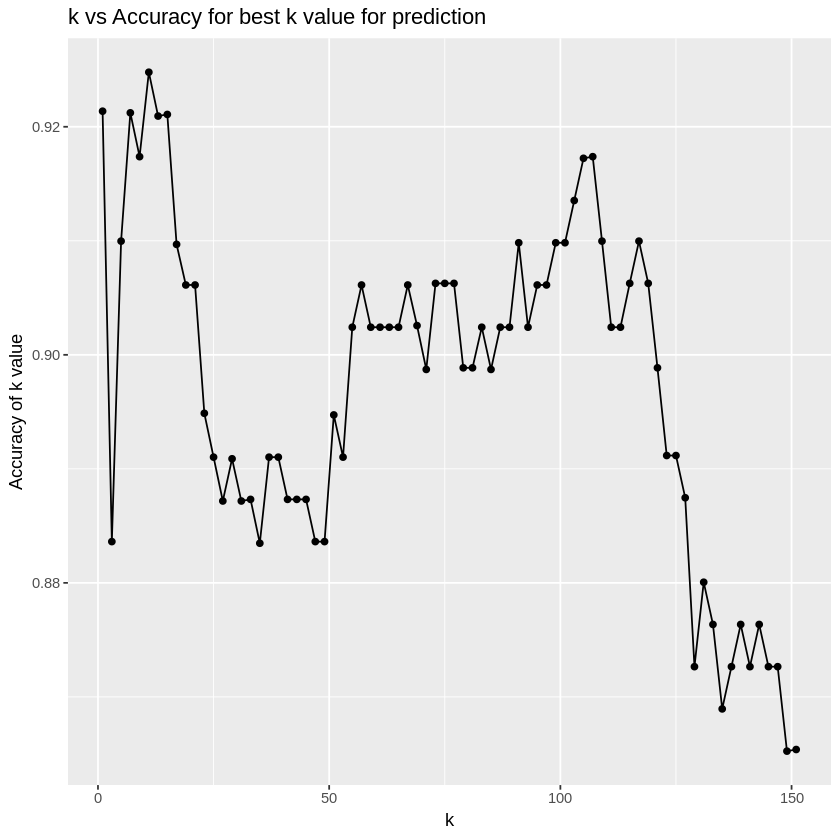

In [55]:
set.seed(4321)
X_train_bu_hemo_sod_rbcc <- kidney_scaled_training %>%
    select(bu, hemo, sod, rbcc) %>%
    data.frame()

X_test_bu_hemo_sod_rbcc <- kidney_scaled_testing %>%
    select(bu, hemo, sod, rbcc) %>%
    data.frame()

choose_k_bu_hemo_sod_rbcc <- train(x = X_train_bu_hemo_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_hemo_sod_rbcc

k_accuracies_bu_hemo_sod_rbcc <- choose_k_bu_hemo_sod_rbcc$results
head(k_accuracies_bu_hemo_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_hemo_sod_rbcc <- k_accuracies_bu_hemo_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_hemo_sod_rbcc

set.seed(4321)

k_bu_hemo_sod_rbcc <- data.frame(k = 11)

knn_class_model_bu_hemo_sod_rbcc <- train(x = X_train_bu_hemo_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_hemo_sod_rbcc)
knn_class_model_bu_hemo_sod_rbcc


test_pred_bu_hemo_sod_rbcc <- predict(object = knn_class_model_bu_hemo_sod_rbcc, X_test_bu_hemo_sod_rbcc)
print(test_pred_bu_hemo_sod_rbcc)

confusionMatrix(test_pred_bu_hemo_sod_rbcc, Y_test)

modelvalues_bu_hemo_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_hemo_sod_rbcc)
test_results_bu_hemo_sod_rbcc <- defaultSummary(modelvalues_bu_hemo_sod_rbcc)
test_results_bu_hemo_sod_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9062678  0.7987200
    3  0.8984330  0.7834150
    5  0.8985755  0.7842798
    7  0.9133903  0.8178225
    9  0.9170940  0.8259112
   11  0.9096866  0.8076160
   13  0.9096866  0.8084177
   15  0.9022792  0.7928558
   17  0.9172365  0.8254818
   19  0.9061254  0.8017712
   21  0.9099715  0.8093915
   23  0.9210826  0.8337108
   25  0.9210826  0.8343344
   27  0.9136752  0.8187531
   29  0.9210826  0.8344630
   31  0.9136752  0.8185477
   33  0.9136752  0.8185477
   35  0.9136752  0.8185477
   37  0.9173789  0.8266364
   39  0.9210826  0.8350927
   41  0.9323362  0.8581973
   43  0.9323362  0.8575692
   45  0.9323362  0.8575625
   47  0.9358974  0.8659419
   49  0.9284900  0.8496412
   51  0.9286325  0.8500892
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9062678,0.7987200,0.03190092,0.07405337
3,0.8984330,0.7834150,0.04833076,0.10379124
5,0.8985755,0.7842798,0.05135147,0.10819223
7,0.9133903,0.8178225,0.05466902,0.11191932
9,0.9170940,0.8259112,0.05407605,0.11072018
11,0.9096866,0.8076160,0.05768478,0.12179235


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.8999843  0.7894611

Tuning parameter 'k' was held constant at a value of 47

 [1] notckd ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     26      0
    notckd   2     44
                                          
               Accuracy : 0.9722          
                 95% CI : (0.9032, 0.9966)
    No Information Rate : 0.6111          
    P-Value [Acc > NIR] : 4.314e-13       
                                          
                  Kappa : 0.9408          
 Mcnemar's Test P-Value : 0.4795          
                                          
            Sensitivity : 0.9286          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9565          
             Prevalence : 0.3889          
         Detection Rate : 0.3611          
   Detection Prevalence : 0.3611          
      Balanced Accuracy : 0.9643          
                                          
       'Positive' Class : ckd             
                                          

Accuracy     Kappa 
0.9722222 0.9407895

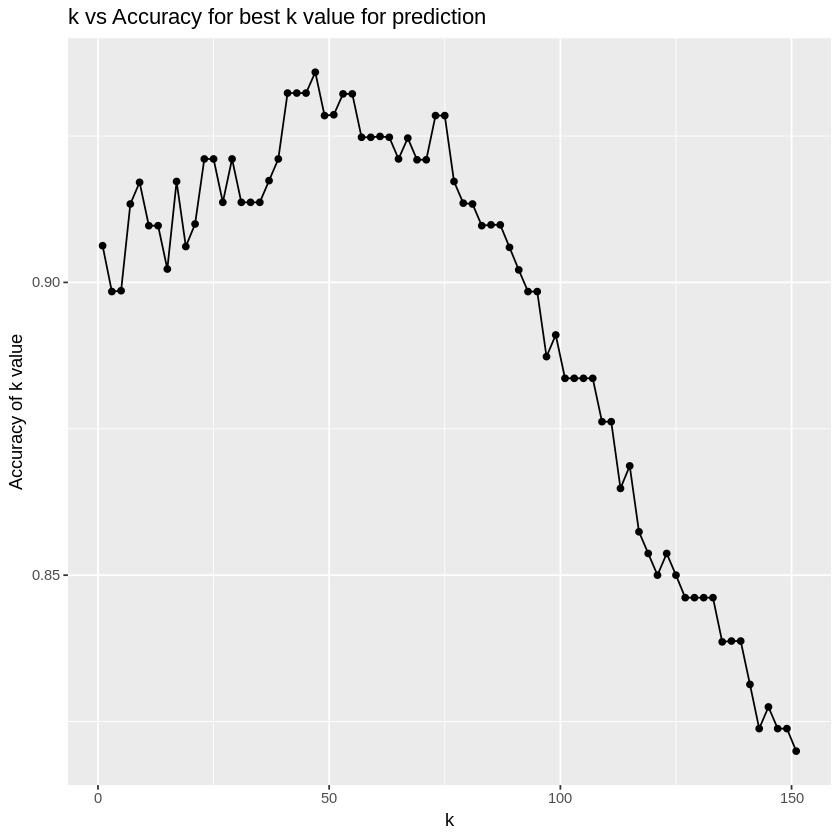

In [56]:
set.seed(4321)
X_train_bu_pcv_sc_sod <- kidney_scaled_training %>%
    select(bu, pcv, sc, sod) %>%
    data.frame()

X_test_bu_pcv_sc_sod <- kidney_scaled_testing %>%
    select(bu, pcv, sc, sod) %>%
    data.frame()

choose_k_bu_pcv_sc_sod <- train(x = X_train_bu_pcv_sc_sod, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_pcv_sc_sod

k_accuracies_bu_pcv_sc_sod <- choose_k_bu_pcv_sc_sod$results
head(k_accuracies_bu_pcv_sc_sod)

#options(repr.plot.width = 5)
cross_val_plot_bu_pcv_sc_sod <- k_accuracies_bu_pcv_sc_sod %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_pcv_sc_sod

set.seed(4321)

k_bu_pcv_sc_sod <- data.frame(k = 47)

knn_class_model_bu_pcv_sc_sod <- train(x = X_train_bu_pcv_sc_sod, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_pcv_sc_sod)
knn_class_model_bu_pcv_sc_sod


test_pred_bu_pcv_sc_sod <- predict(object = knn_class_model_bu_pcv_sc_sod, X_test_bu_pcv_sc_sod)
print(test_pred_bu_pcv_sc_sod)

confusionMatrix(test_pred_bu_pcv_sc_sod, Y_test)

modelvalues_bu_pcv_sc_sod <- data.frame(obs = Y_test, pred = test_pred_bu_pcv_sc_sod)
test_results_bu_pcv_sc_sod <- defaultSummary(modelvalues_bu_pcv_sc_sod)
test_results_bu_pcv_sc_sod

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9059829  0.8001819
    3  0.9133903  0.8134041
    5  0.9245014  0.8403759
    7  0.9206553  0.8326304
    9  0.9094017  0.8078702
   11  0.9056980  0.7997689
   13  0.9058405  0.7984376
   15  0.9058405  0.7984376
   17  0.9058405  0.7973700
   19  0.9095442  0.8068939
   21  0.9095442  0.8065651
   23  0.9170940  0.8235950
   25  0.9170940  0.8243805
   27  0.9133903  0.8151387
   29  0.9172365  0.8242615
   31  0.9173789  0.8229504
   33  0.9135328  0.8143155
   35  0.9135328  0.8146095
   37  0.9135328  0.8146095
   39  0.9209402  0.8308454
   41  0.9209402  0.8308190
   43  0.9172365  0.8226764
   45  0.9172365  0.8223824
   47  0.9172365  0.8238250
   49  0.9246439  0.8403482
   51  0.9283476  0.8481224
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9059829,0.8001819,0.05170676,0.1084561
3,0.9133903,0.8134041,0.06209185,0.1393636
5,0.9245014,0.8403759,0.05441355,0.1142953
7,0.9206553,0.8326304,0.06166280,0.1262139
9,0.9094017,0.8078702,0.05863073,0.1186013
11,0.9056980,0.7997689,0.05598127,0.1125366


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.8996467  0.7844683

Tuning parameter 'k' was held constant at a value of 71

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd ckd    notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd ckd    notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      2
    notckd   1     42
                                         
               Accuracy : 0.9583         
                 95% CI : (0.883, 0.9913)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 6.559e-12      
                                         
                  Kappa : 0.9129         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 0.9545         
         Pos Pred Value : 0.9310         
         Neg Pred Value : 0.9767         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.4028         
      Balanced Accuracy : 0.9594         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9583333 0.9129032

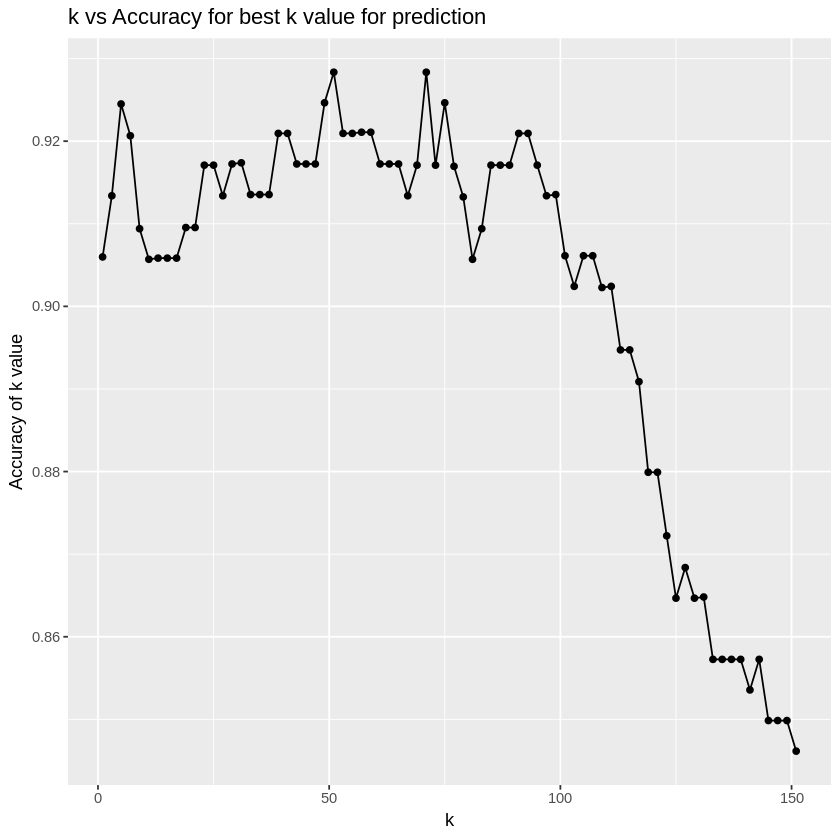

In [57]:
set.seed(4321)
X_train_bu_pcv_sc_rbcc <- kidney_scaled_training %>%
    select(bu, pcv, sc, rbcc) %>%
    data.frame()

X_test_bu_pcv_sc_rbcc <- kidney_scaled_testing %>%
    select(bu, pcv, sc, rbcc) %>%
    data.frame()

choose_k_bu_pcv_sc_rbcc <- train(x = X_train_bu_pcv_sc_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_pcv_sc_rbcc

k_accuracies_bu_pcv_sc_rbcc <- choose_k_bu_pcv_sc_rbcc$results
head(k_accuracies_bu_pcv_sc_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_pcv_sc_rbcc <- k_accuracies_bu_pcv_sc_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_pcv_sc_rbcc

set.seed(4321)

k_bu_pcv_sc_rbcc <- data.frame(k = 71)

knn_class_model_bu_pcv_sc_rbcc <- train(x = X_train_bu_pcv_sc_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_pcv_sc_rbcc)
knn_class_model_bu_pcv_sc_rbcc


test_pred_bu_pcv_sc_rbcc <- predict(object = knn_class_model_bu_pcv_sc_rbcc, X_test_bu_pcv_sc_rbcc)
print(test_pred_bu_pcv_sc_rbcc)

confusionMatrix(test_pred_bu_pcv_sc_rbcc, Y_test)

modelvalues_bu_pcv_sc_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_pcv_sc_rbcc)
test_results_bu_pcv_sc_rbcc <- defaultSummary(modelvalues_bu_pcv_sc_rbcc)
test_results_bu_pcv_sc_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.8800570  0.7400828
    3  0.8834758  0.7516328
    5  0.9095442  0.8103150
    7  0.9056980  0.7992666
    9  0.8908832  0.7661572
   11  0.8833333  0.7457066
   13  0.8870370  0.7549301
   15  0.8796296  0.7380022
   17  0.8833333  0.7451290
   19  0.8833333  0.7451290
   21  0.8907407  0.7612753
   23  0.8833333  0.7451080
   25  0.8870370  0.7535298
   27  0.8833333  0.7451080
   29  0.8796296  0.7363178
   31  0.8759259  0.7278758
   33  0.8796296  0.7363178
   35  0.8759259  0.7278758
   37  0.8720798  0.7199182
   39  0.8759259  0.7278758
   41  0.8759259  0.7278758
   43  0.8722222  0.7190713
   45  0.8646724  0.7006513
   47  0.8683761  0.7094271
   49  0.8833333  0.7458752
   51  0.8833333  0.7458752
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.8800570,0.7400828,0.06061082,0.13615335
3,0.8834758,0.7516328,0.04976838,0.10175722
5,0.9095442,0.8103150,0.04870809,0.09890474
7,0.9056980,0.7992666,0.07027797,0.14986132
9,0.8908832,0.7661572,0.05847670,0.12372101
11,0.8833333,0.7457066,0.05904172,0.12861958


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.8780353  0.7313526

Tuning parameter 'k' was held constant at a value of 5

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd ckd    notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd ckd   
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd ckd   
[61] notckd notckd notckd ckd    notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      4
    notckd   1     40
                                          
               Accuracy : 0.9306          
                 95% CI : (0.8453, 0.9771)
    No Information Rate : 0.6111          
    P-Value [Acc > NIR] : 6.56e-10        
                                          
                  Kappa : 0.8567          
 Mcnemar's Test P-Value : 0.3711          
                                          
            Sensitivity : 0.9643          
            Specificity : 0.9091          
         Pos Pred Value : 0.8710          
         Neg Pred Value : 0.9756          
             Prevalence : 0.3889          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.4306          
      Balanced Accuracy : 0.9367          
                                          
       'Positive' Class : ckd             
                                          

Accuracy     Kappa 
0.9305556 0.8566879

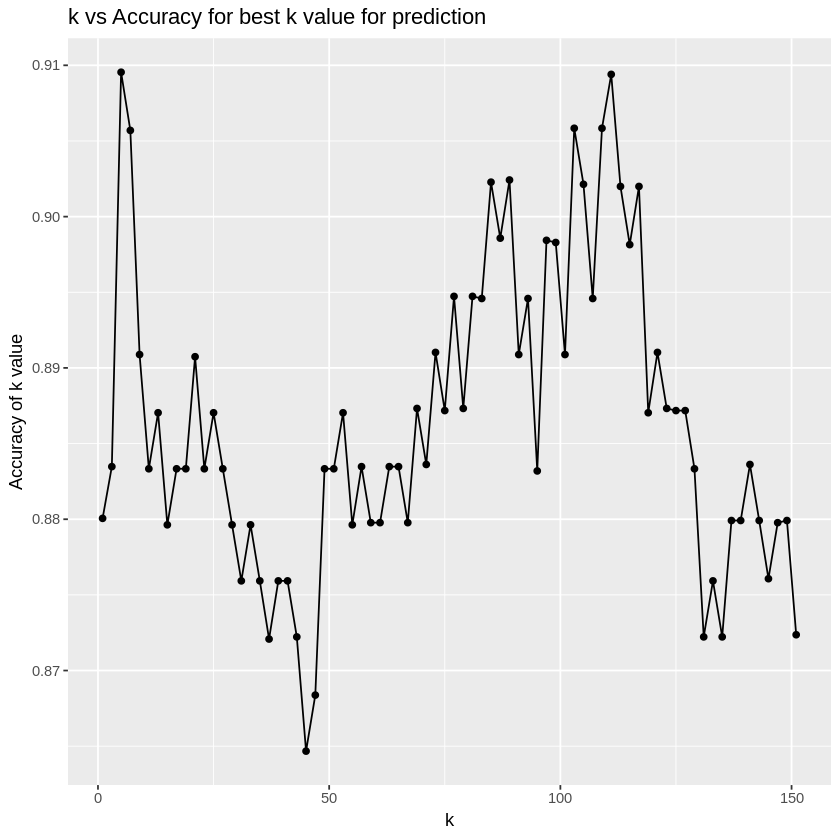

In [58]:
set.seed(4321)
X_train_bu_pcv_sod_rbcc <- kidney_scaled_training %>%
    select(bu, pcv, sod, rbcc) %>%
    data.frame()

X_test_bu_pcv_sod_rbcc <- kidney_scaled_testing %>%
    select(bu, pcv, sod, rbcc) %>%
    data.frame()

choose_k_bu_pcv_sod_rbcc <- train(x = X_train_bu_pcv_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_pcv_sod_rbcc

k_accuracies_bu_pcv_sod_rbcc <- choose_k_bu_pcv_sod_rbcc$results
head(k_accuracies_bu_pcv_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_pcv_sod_rbcc <- k_accuracies_bu_pcv_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_pcv_sod_rbcc

set.seed(4321)

k_bu_pcv_sod_rbcc <- data.frame(k = 5)

knn_class_model_bu_pcv_sod_rbcc <- train(x = X_train_bu_pcv_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_pcv_sod_rbcc)
knn_class_model_bu_pcv_sod_rbcc


test_pred_bu_pcv_sod_rbcc <- predict(object = knn_class_model_bu_pcv_sod_rbcc, X_test_bu_pcv_sod_rbcc)
print(test_pred_bu_pcv_sod_rbcc)

confusionMatrix(test_pred_bu_pcv_sod_rbcc, Y_test)

modelvalues_bu_pcv_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_pcv_sod_rbcc)
test_results_bu_pcv_sod_rbcc <- defaultSummary(modelvalues_bu_pcv_sod_rbcc)
test_results_bu_pcv_sod_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.8987179  0.7835117
    3  0.9101140  0.8075248
    5  0.9175214  0.8233473
    7  0.9210826  0.8295043
    9  0.9210826  0.8277209
   11  0.9133903  0.8109058
   13  0.9209402  0.8281149
   15  0.9210826  0.8282493
   17  0.9133903  0.8113840
   19  0.9059829  0.7934376
   21  0.9059829  0.7944908
   23  0.9133903  0.8110358
   25  0.9098291  0.8034177
   27  0.9173789  0.8198437
   29  0.9173789  0.8198437
   31  0.9173789  0.8198437
   33  0.9212251  0.8300277
   35  0.9138177  0.8155410
   37  0.9101140  0.8078971
   39  0.8988604  0.7819354
   41  0.9064103  0.7997957
   43  0.9062678  0.7974667
   45  0.9098291  0.8050312
   47  0.9099715  0.8065266
   49  0.9022792  0.7889128
   51  0.9098291  0.8065036
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.8987179,0.7835117,0.05915999,0.12490019
3,0.9101140,0.8075248,0.05052218,0.10619900
5,0.9175214,0.8233473,0.04628327,0.09862453
7,0.9210826,0.8295043,0.04211431,0.09324417
9,0.9210826,0.8277209,0.04532711,0.10414984
11,0.9133903,0.8109058,0.05488717,0.12749524


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.8701268  0.7259066

Tuning parameter 'k' was held constant at a value of 81

 [1] notckd ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    notckd ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     25      0
    notckd   3     44
                                         
               Accuracy : 0.9583         
                 95% CI : (0.883, 0.9913)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 6.559e-12      
                                         
                  Kappa : 0.9106         
 Mcnemar's Test P-Value : 0.2482         
                                         
            Sensitivity : 0.8929         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9362         
             Prevalence : 0.3889         
         Detection Rate : 0.3472         
   Detection Prevalence : 0.3472         
      Balanced Accuracy : 0.9464         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9583333 0.9105960

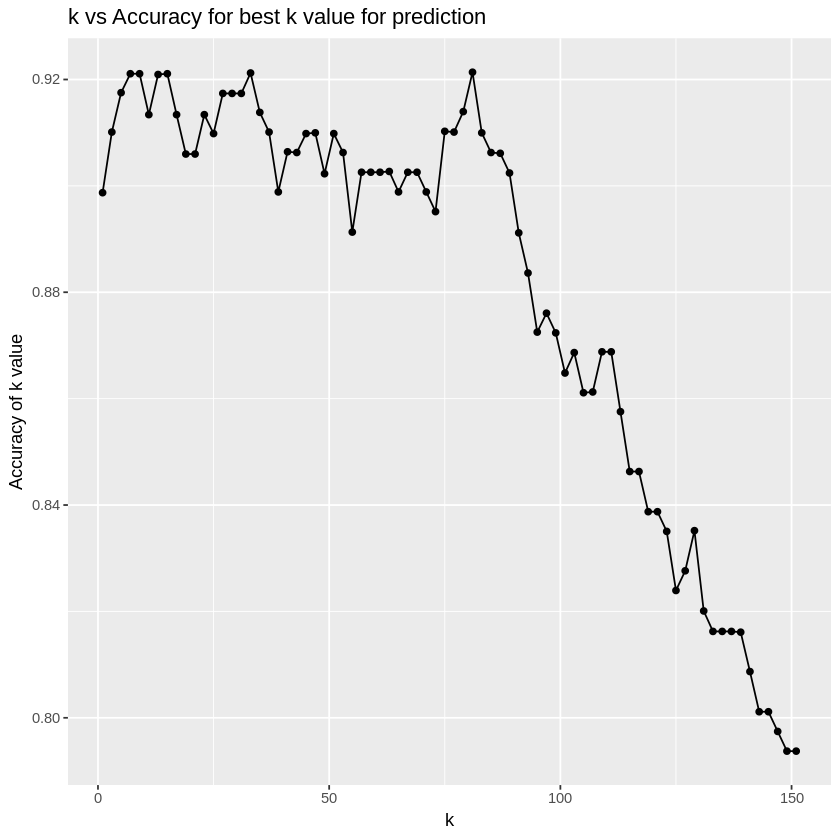

In [59]:
set.seed(4321)
X_train_bu_sc_sod_rbcc <- kidney_scaled_training %>%
    select(bu, sc, sod, rbcc) %>%
    data.frame()

X_test_bu_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(bu, sc, sod, rbcc) %>%
    data.frame()

choose_k_bu_sc_sod_rbcc <- train(x = X_train_bu_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_bu_sc_sod_rbcc

k_accuracies_bu_sc_sod_rbcc <- choose_k_bu_sc_sod_rbcc$results
head(k_accuracies_bu_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_bu_sc_sod_rbcc <- k_accuracies_bu_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_bu_sc_sod_rbcc

set.seed(4321)

k_bu_sc_sod_rbcc <- data.frame(k = 81)

knn_class_model_bu_sc_sod_rbcc <- train(x = X_train_bu_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_bu_sc_sod_rbcc)
knn_class_model_bu_sc_sod_rbcc


test_pred_bu_sc_sod_rbcc <- predict(object = knn_class_model_bu_sc_sod_rbcc, X_test_bu_sc_sod_rbcc)
print(test_pred_bu_sc_sod_rbcc)

confusionMatrix(test_pred_bu_sc_sod_rbcc, Y_test)

modelvalues_bu_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_bu_sc_sod_rbcc)
test_results_bu_sc_sod_rbcc <- defaultSummary(modelvalues_bu_sc_sod_rbcc)
test_results_bu_sc_sod_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9509972  0.8946404
    3  0.9398860  0.8729330
    5  0.9283476  0.8492498
    7  0.9358974  0.8656148
    9  0.9358974  0.8656148
   11  0.9321937  0.8571585
   13  0.9321937  0.8571585
   15  0.9321937  0.8571585
   17  0.9321937  0.8571585
   19  0.9321937  0.8571585
   21  0.9321937  0.8571585
   23  0.9321937  0.8571585
   25  0.9321937  0.8571585
   27  0.9321937  0.8571585
   29  0.9321937  0.8571585
   31  0.9321937  0.8571585
   33  0.9321937  0.8571585
   35  0.9321937  0.8571585
   37  0.9321937  0.8571585
   39  0.9321937  0.8571585
   41  0.9321937  0.8571585
   43  0.9321937  0.8571585
   45  0.9360399  0.8651282
   47  0.9360399  0.8651282
   49  0.9360399  0.8651282
   51  0.9360399  0.8651282
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9509972,0.8946404,0.04018003,0.08451382
3,0.9398860,0.8729330,0.03652704,0.07519744
5,0.9283476,0.8492498,0.05283708,0.10673195
7,0.9358974,0.8656148,0.05149266,0.10286828
9,0.9358974,0.8656148,0.05149266,0.10286828
11,0.9321937,0.8571585,0.05065478,0.10146573


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9366492  0.8633039

Tuning parameter 'k' was held constant at a value of 1

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] ckd    notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      1
    notckd   1     43
                                          
               Accuracy : 0.9722          
                 95% CI : (0.9032, 0.9966)
    No Information Rate : 0.6111          
    P-Value [Acc > NIR] : 4.314e-13       
                                          
                  Kappa : 0.9416          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9643          
            Specificity : 0.9773          
         Pos Pred Value : 0.9643          
         Neg Pred Value : 0.9773          
             Prevalence : 0.3889          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.3889          
      Balanced Accuracy : 0.9708          
                                          
       'Positive' Class : ckd             
                                          

Accuracy     Kappa 
0.9722222 0.9415584

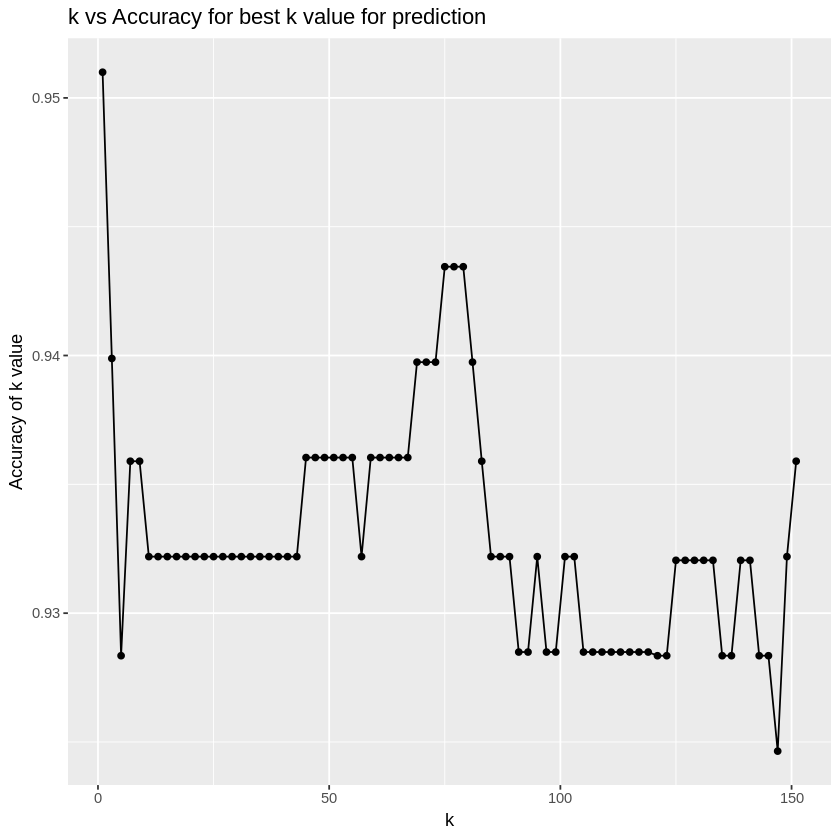

In [60]:
set.seed(4321)
X_train_hemo_pcv_sc_sod <- kidney_scaled_training %>%
    select(hemo, pcv, sc, sod) %>%
    data.frame()

X_test_hemo_pcv_sc_sod <- kidney_scaled_testing %>%
    select(hemo, pcv, sc, sod) %>%
    data.frame()

choose_k_hemo_pcv_sc_sod <- train(x = X_train_hemo_pcv_sc_sod, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_hemo_pcv_sc_sod

k_accuracies_hemo_pcv_sc_sod <- choose_k_hemo_pcv_sc_sod$results
head(k_accuracies_hemo_pcv_sc_sod)

#options(repr.plot.width = 5)
cross_val_plot_hemo_pcv_sc_sod <- k_accuracies_hemo_pcv_sc_sod %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_hemo_pcv_sc_sod

set.seed(4321)

k_hemo_pcv_sc_sod <- data.frame(k = 1)

knn_class_model_hemo_pcv_sc_sod <- train(x = X_train_hemo_pcv_sc_sod, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_hemo_pcv_sc_sod)
knn_class_model_hemo_pcv_sc_sod


test_pred_hemo_pcv_sc_sod <- predict(object = knn_class_model_hemo_pcv_sc_sod, X_test_hemo_pcv_sc_sod)
print(test_pred_hemo_pcv_sc_sod)

confusionMatrix(test_pred_hemo_pcv_sc_sod, Y_test)

modelvalues_hemo_pcv_sc_sod <- data.frame(obs = Y_test, pred = test_pred_hemo_pcv_sc_sod)
test_results_hemo_pcv_sc_sod <- defaultSummary(modelvalues_hemo_pcv_sc_sod)
test_results_hemo_pcv_sc_sod

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9062678  0.7998662
    3  0.8984330  0.7839221
    5  0.9283476  0.8477301
    7  0.9207977  0.8334688
    9  0.9245014  0.8419108
   11  0.9245014  0.8415769
   13  0.9319088  0.8577932
   15  0.9357550  0.8657508
   17  0.9396011  0.8728870
   19  0.9396011  0.8728870
   21  0.9396011  0.8728870
   23  0.9396011  0.8728870
   25  0.9358974  0.8644307
   27  0.9396011  0.8728870
   29  0.9358974  0.8644451
   31  0.9358974  0.8644451
   33  0.9396011  0.8728870
   35  0.9358974  0.8644451
   37  0.9396011  0.8728870
   39  0.9358974  0.8644451
   41  0.9358974  0.8644451
   43  0.9396011  0.8728870
   45  0.9396011  0.8728870
   47  0.9396011  0.8728870
   49  0.9396011  0.8728870
   51  0.9396011  0.8728870
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9062678,0.7998662,0.04449677,0.09560763
3,0.8984330,0.7839221,0.05922322,0.12779296
5,0.9283476,0.8477301,0.04593904,0.09604256
7,0.9207977,0.8334688,0.04976566,0.10015491
9,0.9245014,0.8419108,0.04848888,0.09646015
11,0.9245014,0.8415769,0.05441355,0.11058057


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9267221  0.8424105

Tuning parameter 'k' was held constant at a value of 65

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

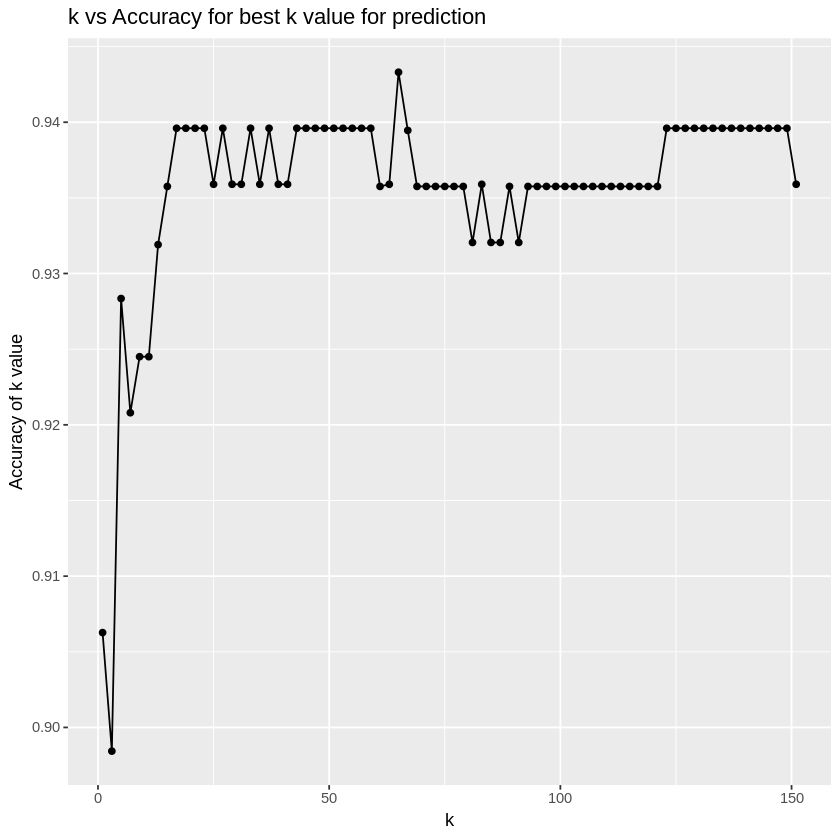

In [61]:
set.seed(4321)
X_train_hemo_pcv_sc_rbcc <- kidney_scaled_training %>%
    select(hemo, pcv, sc, rbcc) %>%
    data.frame()

X_test_hemo_pcv_sc_rbcc <- kidney_scaled_testing %>%
    select(hemo, pcv, sc, rbcc) %>%
    data.frame()

choose_k_hemo_pcv_sc_rbcc <- train(x = X_train_hemo_pcv_sc_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_hemo_pcv_sc_rbcc

k_accuracies_hemo_pcv_sc_rbcc <- choose_k_hemo_pcv_sc_rbcc$results
head(k_accuracies_hemo_pcv_sc_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_hemo_pcv_sc_rbcc <- k_accuracies_hemo_pcv_sc_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_hemo_pcv_sc_rbcc

set.seed(4321)

k_hemo_pcv_sc_rbcc <- data.frame(k = 65)

knn_class_model_hemo_pcv_sc_rbcc <- train(x = X_train_hemo_pcv_sc_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_hemo_pcv_sc_rbcc)
knn_class_model_hemo_pcv_sc_rbcc


test_pred_hemo_pcv_sc_rbcc <- predict(object = knn_class_model_hemo_pcv_sc_rbcc, X_test_hemo_pcv_sc_rbcc)
print(test_pred_hemo_pcv_sc_rbcc)

confusionMatrix(test_pred_hemo_pcv_sc_rbcc, Y_test)

modelvalues_hemo_pcv_sc_rbcc <- data.frame(obs = Y_test, pred = test_pred_hemo_pcv_sc_rbcc)
test_results_hemo_pcv_sc_rbcc <- defaultSummary(modelvalues_hemo_pcv_sc_rbcc)
test_results_hemo_pcv_sc_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9247863  0.8361991
    3  0.9321937  0.8569226
    5  0.9136752  0.8175790
    7  0.9209402  0.8339502
    9  0.9170940  0.8261319
   11  0.9284900  0.8499728
   13  0.9284900  0.8492535
   15  0.9284900  0.8492746
   17  0.9210826  0.8333922
   19  0.9209402  0.8319728
   21  0.9246439  0.8400742
   23  0.9207977  0.8329379
   25  0.9207977  0.8329379
   27  0.9283476  0.8485162
   29  0.9283476  0.8485162
   31  0.9246439  0.8413327
   33  0.9283476  0.8485162
   35  0.9246439  0.8413327
   37  0.9283476  0.8485162
   39  0.9283476  0.8485162
   41  0.9246439  0.8400742
   43  0.9246439  0.8400742
   45  0.9207977  0.8311295
   47  0.9133903  0.8149394
   49  0.9170940  0.8227137
   51  0.9170940  0.8227137
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9247863,0.8361991,0.05036284,0.1109058
3,0.9321937,0.8569226,0.05919713,0.1225357
5,0.9136752,0.8175790,0.05682235,0.1188708
7,0.9209402,0.8339502,0.05793459,0.1208261
9,0.9170940,0.8261319,0.06437037,0.1320056
11,0.9284900,0.8499728,0.05487896,0.1147512


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9012828  0.7837604

Tuning parameter 'k' was held constant at a value of 3

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] ckd    notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd ckd   
[61] notckd notckd notckd notckd ckd    notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      3
    notckd   1     41
                                          
               Accuracy : 0.9444          
                 95% CI : (0.8638, 0.9847)
    No Information Rate : 0.6111          
    P-Value [Acc > NIR] : 7.383e-11       
                                          
                  Kappa : 0.8846          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9643          
            Specificity : 0.9318          
         Pos Pred Value : 0.9000          
         Neg Pred Value : 0.9762          
             Prevalence : 0.3889          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.4167          
      Balanced Accuracy : 0.9481          
                                          
       'Positive' Class : ckd             
                                          

Accuracy     Kappa 
0.9444444 0.8846154

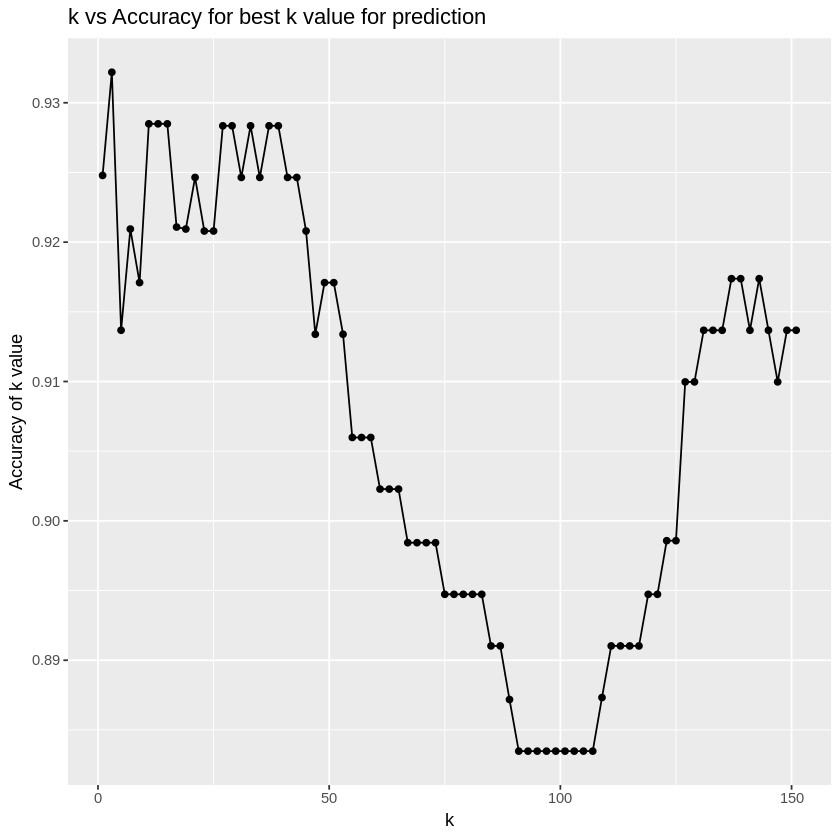

In [62]:
set.seed(4321)
X_train_hemo_pcv_sod_rbcc <- kidney_scaled_training %>%
    select(hemo, pcv, sod, rbcc) %>%
    data.frame()

X_test_hemo_pcv_sod_rbcc <- kidney_scaled_testing %>%
    select(hemo, pcv, sod, rbcc) %>%
    data.frame()

choose_k_hemo_pcv_sod_rbcc <- train(x = X_train_hemo_pcv_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_hemo_pcv_sod_rbcc

k_accuracies_hemo_pcv_sod_rbcc <- choose_k_hemo_pcv_sod_rbcc$results
head(k_accuracies_hemo_pcv_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_hemo_pcv_sod_rbcc <- k_accuracies_hemo_pcv_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_hemo_pcv_sod_rbcc

set.seed(4321)

k_hemo_pcv_sod_rbcc <- data.frame(k = 3)

knn_class_model_hemo_pcv_sod_rbcc <- train(x = X_train_hemo_pcv_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_hemo_pcv_sod_rbcc)
knn_class_model_hemo_pcv_sod_rbcc


test_pred_hemo_pcv_sod_rbcc <- predict(object = knn_class_model_hemo_pcv_sod_rbcc, X_test_hemo_pcv_sod_rbcc)
print(test_pred_hemo_pcv_sod_rbcc)

confusionMatrix(test_pred_hemo_pcv_sod_rbcc, Y_test)

modelvalues_hemo_pcv_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_hemo_pcv_sod_rbcc)
test_results_hemo_pcv_sod_rbcc <- defaultSummary(modelvalues_hemo_pcv_sod_rbcc)
test_results_hemo_pcv_sod_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9172365  0.8234283
    3  0.9246439  0.8419402
    5  0.9321937  0.8574558
    7  0.9360399  0.8660587
    9  0.9321937  0.8578297
   11  0.9284900  0.8497284
   13  0.9397436  0.8745074
   15  0.9321937  0.8578365
   17  0.9360399  0.8660654
   19  0.9360399  0.8660654
   21  0.9321937  0.8574626
   23  0.9320513  0.8569935
   25  0.9320513  0.8569935
   27  0.9320513  0.8569935
   29  0.9320513  0.8569935
   31  0.9397436  0.8735917
   33  0.9397436  0.8735917
   35  0.9397436  0.8735917
   37  0.9396011  0.8731370
   39  0.9396011  0.8731370
   41  0.9320513  0.8557503
   43  0.9320513  0.8557503
   45  0.9394587  0.8722937
   47  0.9357550  0.8638517
   49  0.9394587  0.8722937
   51  0.9433048  0.8794299
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9172365,0.8234283,0.04725706,0.09778002
3,0.9246439,0.8419402,0.04071655,0.08041853
5,0.9321937,0.8574558,0.03974560,0.07954857
7,0.9360399,0.8660587,0.04061675,0.08102794
9,0.9321937,0.8578297,0.05065478,0.10159659
11,0.9284900,0.8497284,0.04949582,0.09909342


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9241863  0.8409931

Tuning parameter 'k' was held constant at a value of 149

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

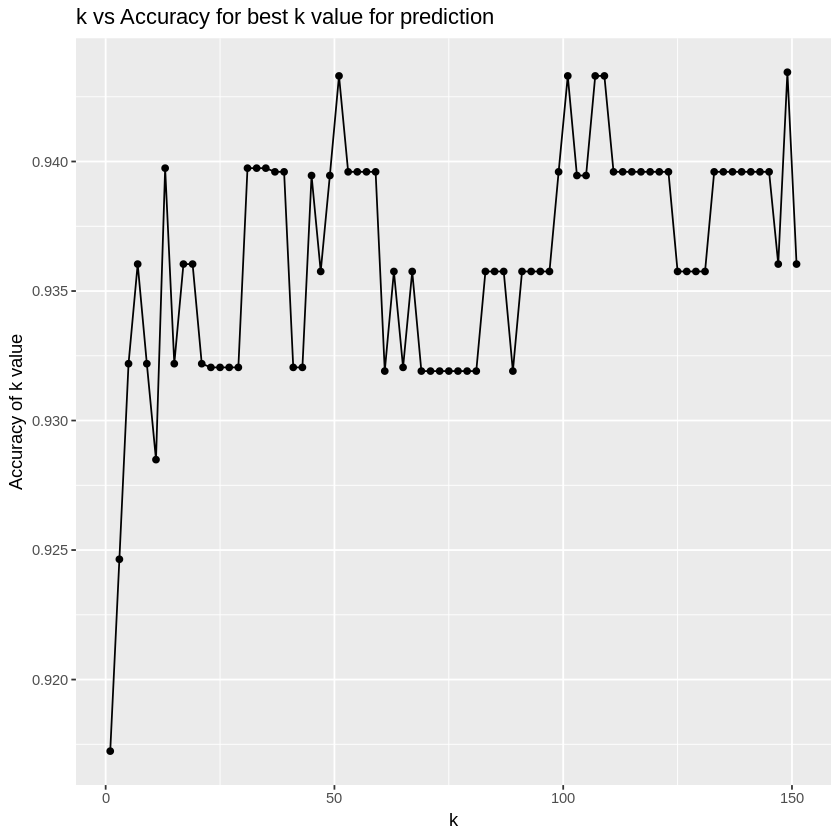

In [63]:
set.seed(4321)
X_train_hemo_sc_sod_rbcc <- kidney_scaled_training %>%
    select(hemo, sc, sod, rbcc) %>%
    data.frame()

X_test_hemo_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(hemo, sc, sod, rbcc) %>%
    data.frame()

choose_k_hemo_sc_sod_rbcc <- train(x = X_train_hemo_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_hemo_sc_sod_rbcc

k_accuracies_hemo_sc_sod_rbcc <- choose_k_hemo_sc_sod_rbcc$results
head(k_accuracies_hemo_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_hemo_sc_sod_rbcc <- k_accuracies_hemo_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_hemo_sc_sod_rbcc

set.seed(4321)

k_hemo_sc_sod_rbcc <- data.frame(k = 149)

knn_class_model_hemo_sc_sod_rbcc <- train(x = X_train_hemo_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_hemo_sc_sod_rbcc)
knn_class_model_hemo_sc_sod_rbcc


test_pred_hemo_sc_sod_rbcc <- predict(object = knn_class_model_hemo_sc_sod_rbcc, X_test_hemo_sc_sod_rbcc)
print(test_pred_hemo_sc_sod_rbcc)

confusionMatrix(test_pred_hemo_sc_sod_rbcc, Y_test)

modelvalues_hemo_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_hemo_sc_sod_rbcc)
test_results_hemo_sc_sod_rbcc <- defaultSummary(modelvalues_hemo_sc_sod_rbcc)
test_results_hemo_sc_sod_rbcc

k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9132479  0.8166626
    3  0.9207977  0.8328907
    5  0.9283476  0.8497569
    7  0.9246439  0.8426513
    9  0.9246439  0.8426513
   11  0.9247863  0.8420470
   13  0.9321937  0.8582632
   15  0.9284900  0.8504890
   17  0.9321937  0.8582632
   19  0.9209402  0.8341392
   21  0.9246439  0.8415998
   23  0.9283476  0.8493741
   25  0.9209402  0.8334572
   27  0.9246439  0.8409178
   29  0.9283476  0.8493741
   31  0.9245014  0.8404671
   33  0.9170940  0.8239238
   35  0.9209402  0.8312115
   37  0.9282051  0.8482414
   39  0.9245014  0.8401527
   41  0.9245014  0.8397851
   43  0.9207977  0.8316964
   45  0.9170940  0.8229911
   47  0.9209402  0.8315647
   49  0.9132479  0.8150042
   51  0.9170940  0.8229619
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9132479,0.8166626,0.04510896,0.09163830
3,0.9207977,0.8328907,0.04293086,0.08545397
5,0.9283476,0.8497569,0.03873928,0.07616270
7,0.9246439,0.8426513,0.04071655,0.08022294
9,0.9246439,0.8426513,0.04071655,0.08022294
11,0.9247863,0.8420470,0.03596094,0.07423623


k-Nearest Neighbors 

267 samples
  4 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9195985  0.8281809

Tuning parameter 'k' was held constant at a value of 17

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

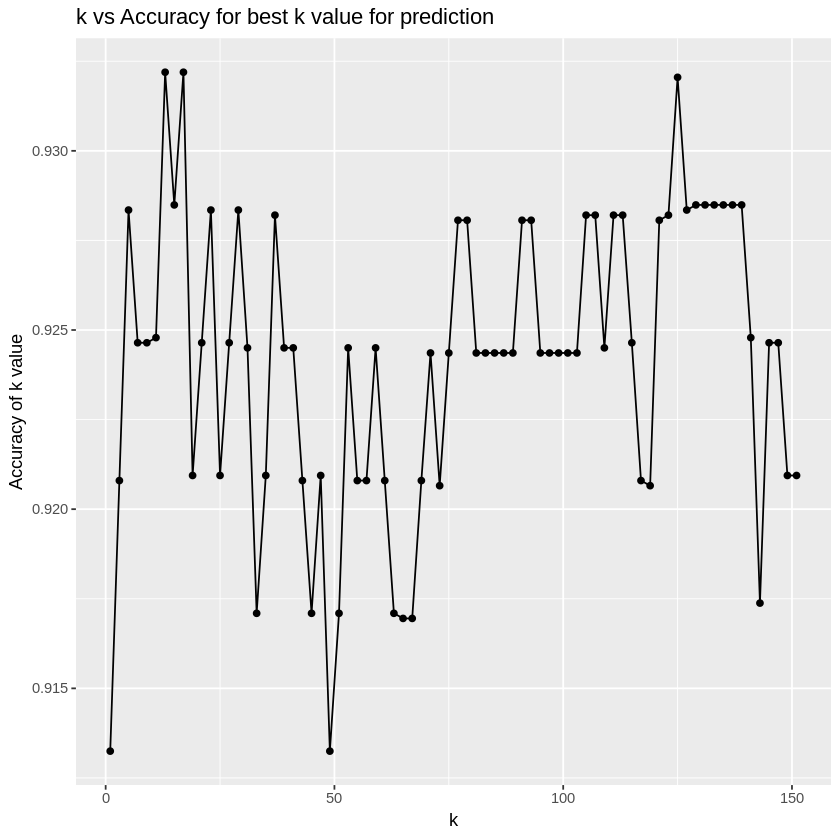

In [64]:
set.seed(4321)
X_train_pcv_sc_sod_rbcc <- kidney_scaled_training %>%
    select(pcv, sc, sod, rbcc) %>%
    data.frame()

X_test_pcv_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(pcv, sc, sod, rbcc) %>%
    data.frame()

choose_k_pcv_sc_sod_rbcc <- train(x = X_train_pcv_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_pcv_sc_sod_rbcc

k_accuracies_pcv_sc_sod_rbcc <- choose_k_pcv_sc_sod_rbcc$results
head(k_accuracies_pcv_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_pcv_sc_sod_rbcc <- k_accuracies_pcv_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_pcv_sc_sod_rbcc

set.seed(4321)

k_pcv_sc_sod_rbcc <- data.frame(k = 17)

knn_class_model_pcv_sc_sod_rbcc <- train(x = X_train_pcv_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_pcv_sc_sod_rbcc)
knn_class_model_pcv_sc_sod_rbcc


test_pred_pcv_sc_sod_rbcc <- predict(object = knn_class_model_pcv_sc_sod_rbcc, X_test_pcv_sc_sod_rbcc)
print(test_pred_pcv_sc_sod_rbcc)

confusionMatrix(test_pred_pcv_sc_sod_rbcc, Y_test)

modelvalues_pcv_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_pcv_sc_sod_rbcc)
test_results_pcv_sc_sod_rbcc <- defaultSummary(modelvalues_pcv_sc_sod_rbcc)
test_results_pcv_sc_sod_rbcc

# below is the code for the final knn classification model

In [66]:
set.seed(4321)
X_train_hemo_pcv_sc_sod_rbcc <- kidney_scaled_training %>%
    select(hemo, pcv, sc, sod, rbcc) %>%
    data.frame()

X_test_hemo_pcv_sc_sod_rbcc <- kidney_scaled_testing %>%
    select(hemo, pcv, sc, sod, rbcc) %>%
    data.frame()

choose_k_hemo_pcv_sc_sod_rbcc <- train(x = X_train_hemo_pcv_sc_sod_rbcc, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_hemo_pcv_sc_sod_rbcc

k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.9289174  0.8483797
    3  0.9135328  0.8153577
    5  0.9284900  0.8482128
    7  0.9320513  0.8582758
    9  0.9320513  0.8582758
   11  0.9357550  0.8663839
   13  0.9396011  0.8743537
   15  0.9357550  0.8657508
   17  0.9357550  0.8657508
   19  0.9396011  0.8728870
   21  0.9396011  0.8728870
   23  0.9396011  0.8728870
   25  0.9396011  0.8728870
   27  0.9396011  0.8728870
   29  0.9396011  0.8728870
   31  0.9396011  0.8728870
   33  0.9396011  0.8728870
   35  0.9396011  0.8728870
   37  0.9396011  0.8728870
   39  0.9396011  0.8728870
   41  0.9396011  0.8728870
   43  0.9357550  0.8639423
   45  0.9396011  0.8728870
   47  0.9396011  0.8728870
   49  0.9396011  0.8728870
   51  0.9396011  0.8728870
  

k,Accuracy,Kappa,AccuracySD,KappaSD
1,0.9289174,0.8483797,0.04099799,0.08865383
3,0.9135328,0.8153577,0.04384467,0.09533974
5,0.9284900,0.8482128,0.03825758,0.07871125
7,0.9320513,0.8582758,0.04770154,0.09360357
9,0.9320513,0.8582758,0.04770154,0.09360357
11,0.9357550,0.8663839,0.05164328,0.10252664


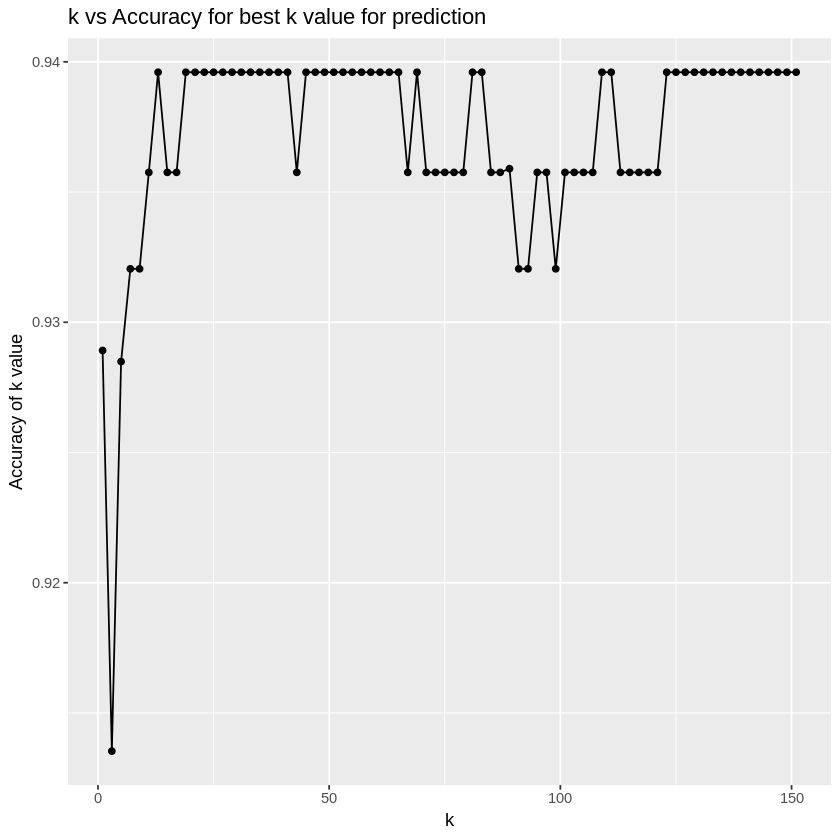

In [67]:
k_accuracies_hemo_pcv_sc_sod_rbcc <- choose_k_hemo_pcv_sc_sod_rbcc$results
head(k_accuracies_hemo_pcv_sc_sod_rbcc)

#options(repr.plot.width = 5)
cross_val_plot_hemo_pcv_sc_sod_rbcc <- k_accuracies_hemo_pcv_sc_sod_rbcc %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_hemo_pcv_sc_sod_rbcc

In [68]:
set.seed(4321)

k_hemo_pcv_sc_sod_rbcc <- data.frame(k = 151)

knn_class_model_hemo_pcv_sc_sod_rbcc <- train(x = X_train_hemo_pcv_sc_sod_rbcc, 
                                            y = Y_train, method = "knn", 
                                            tuneGrid = k_hemo_pcv_sc_sod_rbcc)
knn_class_model_hemo_pcv_sc_sod_rbcc


k-Nearest Neighbors 

267 samples
  5 predictor
  2 classes: 'ckd', 'notckd' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 267, 267, 267, 267, 267, 267, ... 
Resampling results:

  Accuracy   Kappa    
  0.9319147  0.8559545

Tuning parameter 'k' was held constant at a value of 151

In [69]:
test_pred_hemo_pcv_sc_sod_rbcc <- predict(object = knn_class_model_hemo_pcv_sc_sod_rbcc, X_test_hemo_pcv_sc_sod_rbcc)
print(test_pred_hemo_pcv_sc_sod_rbcc)

confusionMatrix(test_pred_hemo_pcv_sc_sod_rbcc, Y_test)

modelvalues_hemo_pcv_sc_sod_rbcc <- data.frame(obs = Y_test, pred = test_pred_hemo_pcv_sc_sod_rbcc)
test_results_hemo_pcv_sc_sod_rbcc <- defaultSummary(modelvalues_hemo_pcv_sc_sod_rbcc)
test_results_hemo_pcv_sc_sod_rbcc

 [1] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd   
[11] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd ckd   
[21] ckd    ckd    ckd    ckd    ckd    ckd    ckd    ckd    notckd notckd
[31] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[41] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[51] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[61] notckd notckd notckd notckd notckd notckd notckd notckd notckd notckd
[71] notckd notckd
Levels: ckd notckd


Confusion Matrix and Statistics

          Reference
Prediction ckd notckd
    ckd     27      0
    notckd   1     44
                                         
               Accuracy : 0.9861         
                 95% CI : (0.925, 0.9996)
    No Information Rate : 0.6111         
    P-Value [Acc > NIR] : 1.867e-14      
                                         
                  Kappa : 0.9706         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9643         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9778         
             Prevalence : 0.3889         
         Detection Rate : 0.3750         
   Detection Prevalence : 0.3750         
      Balanced Accuracy : 0.9821         
                                         
       'Positive' Class : ckd            
                                         

Accuracy     Kappa 
0.9861111 0.9705882

# <font color='blue'>How we came to the conclusion of building the classification model this way</font>

Through initial discussion with TAs, it was decided to replace all NA values in the original data set with the column means then split it into a training and testing set and building the classification model off of those tables, however after further discussion with the TAs, they recommended that splitting the data into the training set and testing set first then filling the training set NA values with its column means while the testing data set has something similar done on its own. Then after discussion with Prof. Timbers, she came to the conclusion that altering the testing data set in that manner would be violating the "golden rule of machine learning," so we decided to simply omit all data entries in the testing set with NA values before building the classification model.

Here is a table of the different combinations and their accruacies summarized in one table.
## Table separating Quantitative and Qualitative data ##
|Factor| Training Accuracy | Testing Accruacy|
----|------------------------------|-----------------|
|bu, hemo, pcv, sc, sod, rbcc| 0.9222668  |0.986111111111111|
|hemo, pcv, rbcc, sc, sod| 0.9396011               |0.986111111111111|
|hemo_pcv_rbcc_sc| 0.9267221         |0.986111111111111|
|hemo_pcv_rbcc| 0.8980934    |0.944444444444444|
|hemo_pcv| 0.9170728               |0.972222222222222|



Our approach is to use the forward-step selection process to determine which variables to include in the models. Rather than training models for each individual variables, we decided the final model will have more than one variable. We decided to start with four variables. From there on, we did different combinations of four variables then, we added another variable and did combinations with those variables as well. In the end, we have a model with all variables in it. So basically we tried models through doing n Choose x combinations where n = 6 and x = 4, 5 or 6.


In [65]:

a <- tibble(knn_class_model_all = c(knn_class_model_all$results)) %>% t() %>% data.frame()            
b <- tibble(knn_class_model_bu_hemo_pcv_sc_sod = c(knn_class_model_bu_hemo_pcv_sc_sod$results)) %>% t() %>% data.frame()
c <- tibble(knn_class_model_bu_hemo_pcv_sc_rbcc = c(knn_class_model_bu_hemo_pcv_sc_rbcc$results)) %>% t() %>% data.frame()
d <- tibble(knn_class_model_bu_hemo_pcv_sod_rbcc = c(knn_class_model_bu_hemo_pcv_sod_rbcc$results)) %>% t() %>% data.frame()
e <- tibble(knn_class_model_bu_hemo_sc_sod_rbcc = c(knn_class_model_bu_hemo_sc_sod_rbcc$results)) %>% t() %>% data.frame()
f <- tibble(knn_class_model_bu_pcv_sc_sod_rbcc = c(knn_class_model_bu_pcv_sc_sod_rbcc$results)) %>% t() %>% data.frame()
g <- tibble(knn_class_model_hemo_pcv_sc_sod_rbcc = c(knn_class_model_hemo_pcv_sc_sod_rbcc$results)) %>% t() %>% data.frame()
h <- tibble(knn_class_model_bu_hemo_pcv_sc = c (knn_class_model_bu_hemo_pcv_sc$results)) %>% t() %>% data.frame()
i <- tibble(knn_class_model_bu_hemo_pcv_sod = c(knn_class_model_bu_hemo_pcv_sod$results)) %>% t() %>% data.frame()
j <- tibble(knn_class_model_bu_hemo_pcv_rbcc = c(knn_class_model_bu_hemo_pcv_rbcc$results)) %>% t() %>% data.frame()
l <- tibble(knn_class_model_bu_hemo_sc_sod = c(knn_class_model_bu_hemo_sc_sod$results)) %>% t() %>% data.frame()
m <- tibble(knn_class_model_bu_hemo_sc_rbcc = c(knn_class_model_bu_hemo_sc_rbcc$results)) %>% t() %>% data.frame()
n <- tibble(knn_class_model_bu_hemo_sod_rbcc = c(knn_class_model_bu_hemo_sod_rbcc$results)) %>% t() %>% data.frame()
o <- tibble(knn_class_model_bu_pcv_sc_sod = c(knn_class_model_bu_pcv_sc_sod$results)) %>% t() %>% data.frame()
p <- tibble(knn_class_model_bu_pcv_sc_rbcc = c(knn_class_model_bu_pcv_sc_rbcc$results)) %>% t() %>% data.frame()
q <- tibble(knn_class_model_bu_pcv_sod_rbcc = c(knn_class_model_bu_pcv_sod_rbcc$results)) %>% t() %>% data.frame()
r <- tibble(knn_class_model_bu_sc_sod_rbcc = c(knn_class_model_bu_sc_sod_rbcc$results)) %>% t() %>% data.frame()
s <- tibble(knn_class_model_hemo_pcv_sc_sod = c(knn_class_model_hemo_pcv_sc_sod$results)) %>% t() %>% data.frame()
t <- tibble(knn_class_model_hemo_pcv_sc_rbcc = c(knn_class_model_hemo_pcv_sc_rbcc$results)) %>% t() %>% data.frame()
u <- tibble(knn_class_model_hemo_pcv_sod_rbcc = c(knn_class_model_hemo_pcv_sod_rbcc$results)) %>% t() %>% data.frame()
v <- tibble(knn_class_model_hemo_sc_sod_rbcc = c(knn_class_model_hemo_sc_sod_rbcc$results)) %>% t() %>% data.frame()
w <- tibble(knn_class_model_pcv_sc_sod_rbcc = c(knn_class_model_pcv_sc_sod_rbcc$results)) %>% t() %>% data.frame()


names <- tibble("all", 
               "bu_hemo_pcv_sc_sod", 
               "bu_hemo_pcv_sc_rbcc", 
               "bu_hemo_pcv_sod_rbcc", 
               "bu_hemo_sc_sod_rbcc", 
               "bu_pcv_sc_sod_rbcc", 
               "hemo_pcv_sc_sod_rbcc", 
               "bu_hemo_pcv_sc", 
               "bu_hemo_pcv_sod", 
               "bu_hemo_pcv_rbcc", 
               "bu_hemo_sc_sod", 
               "bu_hemo_sc_rbcc", 
               "bu_hemo_sod_rbcc", 
               "bu_pcv_sc_sod", 
               "bu_pcv_sc_rbcc", 
               "bu_pcv_sod_rbcc",
               "bu_sc_sod_rbcc", 
               "hemo_pcv_sc_sod", 
               "hemo_pcv_sc_rbcc", 
               "hemo_pcv_sod_rbcc", 
               "hemo_sc_sod_rbcc", 
               "pcv_sc_sod_rbcc") %>% t() %>% data.frame()

knn_results <- bind_rows(a,b,c,d,e,f,g,h,i,j,l,m,n,o,p,q,r,s,t,u,v,w)

knn_result_table <- bind_cols(names, knn_results)
colnames(knn_result_table) <- c("knn_model", "k", "Accuracy", "Kappa", "AccuracySD", "KappaSD")
knn_result_table

results <- data.frame(test_results_all, 
               test_results_bu_hemo_pcv_sc_sod, 
               test_results_bu_hemo_pcv_sc_rbcc, 
               test_results_bu_hemo_pcv_sod_rbcc, 
               test_results_bu_hemo_sc_sod_rbcc, 
               test_results_bu_pcv_sc_sod_rbcc, 
               test_results_hemo_pcv_sc_sod_rbcc, 
               test_results_bu_hemo_pcv_sc, 
               test_results_bu_hemo_pcv_sod, 
               test_results_bu_hemo_pcv_rbcc, 
               test_results_bu_hemo_sc_sod, 
               test_results_bu_hemo_sc_rbcc, 
               test_results_bu_hemo_sod_rbcc, 
               test_results_bu_pcv_sc_sod, 
               test_results_bu_pcv_sc_rbcc, 
               test_results_bu_pcv_sod_rbcc,
               test_results_bu_sc_sod_rbcc, 
               test_results_hemo_pcv_sc_sod, 
               test_results_hemo_pcv_sc_rbcc, 
               test_results_hemo_pcv_sod_rbcc, 
               test_results_hemo_sc_sod_rbcc, 
               test_results_pcv_sc_sod_rbcc) %>%
t()
results

knn_model,k,Accuracy,Kappa,AccuracySD,KappaSD
all,99,0.9222668,0.8361476,0.03110738,0.06314939
bu_hemo_pcv_sc_sod,19,0.922942,0.8342336,0.02220823,0.04422437
bu_hemo_pcv_sc_rbcc,101,0.919753,0.8311857,0.03138706,0.06364531
bu_hemo_pcv_sod_rbcc,113,0.9166194,0.8244332,0.03194122,0.06387064
bu_hemo_sc_sod_rbcc,63,0.9238647,0.8354547,0.02878915,0.05979424
bu_pcv_sc_sod_rbcc,75,0.9039013,0.794394,0.03681557,0.07645116
hemo_pcv_sc_sod_rbcc,151,0.9319147,0.8559545,0.02722304,0.05511466
bu_hemo_pcv_sc,47,0.9235229,0.8371294,0.02472156,0.04972833
bu_hemo_pcv_sod,123,0.9078092,0.8082534,0.03569792,0.07085432
bu_hemo_pcv_rbcc,113,0.9157048,0.8224216,0.03106951,0.06152761


,Accuracy,Kappa
test_results_all,0.9861111,0.9705882
test_results_bu_hemo_pcv_sc_sod,0.9861111,0.9705882
test_results_bu_hemo_pcv_sc_rbcc,0.9861111,0.9705882
test_results_bu_hemo_pcv_sod_rbcc,0.9861111,0.9705882
test_results_bu_hemo_sc_sod_rbcc,0.9861111,0.9705882
test_results_bu_pcv_sc_sod_rbcc,0.9583333,0.9129032
test_results_hemo_pcv_sc_sod_rbcc,0.9861111,0.9705882
test_results_bu_hemo_pcv_sc,0.9861111,0.9705882
test_results_bu_hemo_pcv_sod,0.9861111,0.9705882
test_results_bu_hemo_pcv_rbcc,0.9861111,0.9705882


Looking at the table above. It is clear that using 5 variables: hemo, pcv, sc, sod, rbcc give the highest average accuracy when taking the mean of the testing and cross validation accuracies. In the final model we decide to use hemo, pcv, sc, sod and rbcc.

# Initial method of how we approached the project where all NA values in the original data were filled with the column means

In [ ]:
class <- kidney %>%                                 # classes for each entry(ckd/notckd)
    select(class)

kidney_scaled <- kidney %>%                         # scaled values for data with class and NA values *NOT* replaced
    select(age, bp, bgr, bu, sc, sc, pot, hemo, pcv, wbcc, rbcc) %>%
    scale(center = FALSE) %>%
    data.frame() %>%
    bind_cols(class)


kidney_quantitative_scaled <- kidney %>%            # only scaled QUANTITATIVE values selected for this table
    select(age, bp, bgr, bu, sc, sc, pot, hemo, pcv, wbcc, rbcc) %>%
    scale(center = FALSE) %>%
    data.frame()


In [ ]:
colMeans(kidney_quantitative_scaled, na.rm = TRUE)                # mean values of each column not including NA values

for(i in 1:ncol(kidney_quantitative_scaled)){                     # kidney_quantitative_scaled
                                                                  # table NA values REPLACED with MEAN values in each column
    kidney_quantitative_scaled[is.na(kidney_quantitative_scaled[,i]), i] <- 
    mean(kidney_quantitative_scaled[,i], na.rm = TRUE)
}

kidney_quantitative_scaled_w_class <- kidney_quantitative_scaled %>%
    bind_cols(class) %>%
    data.frame()                                                   # scaled and NA replaced quantitative table bound to class
                                                                   # table.

In [ ]:
which(is.na(kidney_quantitative_scaled))                            # checking if any NA values still in the table
which(rowSums(is.na(kidney_quantitative_scaled)) != 0)
sum(is.na(kidney_quantitative_scaled))
colSums(is.na(kidney_quantitative_scaled))

kidney_quantitative_scaled_w_class <- na.omit(kidney_quantitative_scaled_w_class) %>% data.frame()    # used to omit rows in CLASS column
head(kidney_quantitative_scaled_w_class)                                              # with NA values (there were 3 rows)

In [ ]:
table <- kidney_quantitative_scaled_w_class



##########################select all############################
set.seed(4321)
#reusable
training_rows <- table %>%
    select(class) %>%
    unlist() %>%
    createDataPartition(p = 0.75, list = FALSE)
head(training_rows)

X_train_all <- table %>%
    select(age, bp, bgr, bu, sc, pot, hemo, pcv, wbcc, rbcc) %>%
    slice(training_rows) %>%
    data.frame()

#reusable don't need new one
Y_train <- table %>%
    select(class) %>%
    slice(training_rows) %>%
    unlist()

X_test_all <- table %>%
    select(age, bp, bgr, bu, sc, pot, hemo, pcv, wbcc, rbcc) %>%
    slice(-training_rows) %>%
    data.frame()

#reusable don't need new one
Y_test <- table %>%
    select(class) %>%
    slice(-training_rows) %>%
    unlist()

#reusable don't need new one
train_control <- trainControl(method = "cv", number = 10)


#reusable don't need new one
find_k <- data.frame(k = seq(from = 1, to = 99, by = 2))
#colnames(find_k) <- c("k")

choose_k_all <- train(x = X_train_all, 
                  y = Y_train, 
                  method = "knn", 
                  tuneGrid = find_k, 
                  trControl = train_control)
choose_k_all

In [ ]:
k_accuracies_all <- choose_k_all$results
head(k_accuracies_all)

#options(repr.plot.width = 5)
cross_val_plot_all <- k_accuracies_all %>%
    ggplot(aes(x = k, y = Accuracy)) +
    geom_point() +
    geom_line() +
    xlab("k") +
    ylab("Accuracy of k value") +
    ggtitle("k vs Accuracy for best k value for prediction")
cross_val_plot_all

In [ ]:
k_all <- data.frame(k = 9)

knn_class_model_all <- train(x = X_train_all, y = Y_train, method = "knn", tuneGrid = k_all)
knn_class_model_all



In [ ]:
test_pred_all <- predict(object = knn_class_model_all, X_test_all)
print(test_pred_all)
confusionMatrix(test_pred_all, Y_test)

# End

Unfortunately the second revision of building the model was not saved as we directly altered it to reach the final revision.